# **Financial Machine Learning Assignment**

Student: B241413

Project choice: Forecasting Stock Volatility - Is stock volatility past-dependent?

Stock Choices:
1. Salesforce (CRM)
2. Goldman Sachs (GS)

In [1]:
#Import necessary libraries for analysis
import os
from os import listdir
import random
import tqdm
import numpy as np
import pandas as pd
import time

import tensorflow as tf
from tensorflow.python import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras import backend as K

from keras.layers import Dense, Embedding, SimpleRNN
from keras.models import Sequential
from scipy import stats

from pprint import pprint
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import *
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from scipy import stats
import scipy.cluster.hierarchy as sch

%matplotlib inline

# These options determine the way floating point numbers are displayed.
np.set_printoptions(precision=4, suppress=True)

tf.random.set_seed(100)

2024-03-01 15:05:53.381410: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/lg/tx14h9yd0y124jv8gq38m0mw0000gn/T/ipykernel_1356/3162438777.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Download stock from Yahoo Finance

In [2]:
### install and import yahoo finance
!pip install -U yfinance
import yfinance as yf

In [3]:
#### Define the stock Start and End Date ####
## you can define a longer time for your own use ##

start = pd.to_datetime('20000101',format='%Y%m%d')
end = pd.to_datetime('20231231',format='%Y%m%d')
days = (end-start).days
print('total days: ', days)

total days:  8765


In [4]:
#Reading the company listed stocks from the file 
# nasdaq_listed.csv contains all company tickers listed in nasdaq
df = pd.read_csv('/Users/benblackwell/Financial-Machine-Learning/nyse-listed.csv')
'''
find all company names listed on NASDAQ and download
the stoke prices from yahoo finance
'''
df.head()
Symbols = df['ACT Symbol'].tolist()

print('total number of tickers: ', len(Symbols))
print('first 10: ', Symbols[:10])



total number of tickers:  3298
first 10:  ['A', 'AA', 'AA$B', 'AAC', 'AAN', 'AAP', 'AAT', 'AAV', 'AB', 'ABB']


In [5]:
import pandas as pd
import yfinance as yf
import time

t0 = time.time()

# Define the stock tickers to retrieve prices for
tickers_to_download = ["GS", "CRM"]

# Define the time period for which you want to retrieve the prices
start = '2020-12-01'
end = '2024-01-01'

# Create empty dataframe
stock_final = pd.DataFrame()

# Empty list for the tickers that are not listed anymore
delisted_stock = []

# Iterate over each symbol
for ticker in tickers_to_download:
    print(f"Downloading data for {ticker}...", end=", ", flush=True)
    try:
        stock = yf.download(ticker, start=start, end=end, progress=False)
        if len(stock) == 0:
            delisted_stock.append(ticker)
        else:
            stock['Name'] = ticker
            stock_final = stock_final.append(stock, sort=False)
    except Exception:
        delisted_stock.append(ticker)

# Calculate total time taken
total_time = (time.time() - t0) / 60

print('\nTotal time:', total_time, 'minutes')
print('Total number of downloaded stocks:', len(stock_final['Name'].unique()))


Total time: 0.013386766115824381 minutes
Total number of downloaded stocks: 2


/var/folders/lg/tx14h9yd0y124jv8gq38m0mw0000gn/T/ipykernel_1356/1943314609.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_final = stock_final.append(stock, sort=False)
/var/folders/lg/tx14h9yd0y124jv8gq38m0mw0000gn/T/ipykernel_1356/1943314609.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_final = stock_final.append(stock, sort=False)


In [6]:
# Date index contains both date and time, we like to remove time information and use date information only

# # make index as a normal column
# stock_final.reset_index( inplace=True )

# # remove time, leave dates only
# stock_final['Date'] = pd.to_datetime(stock_final['Date'], format='%Y-%m-%d').dt.date

# # set index as the date
# stock_final.set_index('Date', inplace=True)

# make index as a normal column
stock_final.reset_index(inplace=True)

# remove time, leave dates only
stock_final['Date'] = pd.to_datetime(stock_final['Date'])

# Set 'Date' as the index
stock_final.set_index('Date', inplace=True)


stock_final.head(10)


,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2020-12-01,231.960007,234.869995,231.350006,232.080002,213.871460,2577600,GS
2020-12-02,232.080002,238.130005,231.580002,237.649994,219.004440,2136300,GS
2020-12-03,237.289993,238.850006,234.639999,235.470001,216.995499,2142600,GS
2020-12-04,237.699997,239.750000,236.949997,239.580002,220.783020,2373000,GS
2020-12-07,238.539993,239.850006,235.449997,238.449997,219.741653,1788600,GS
2020-12-08,237.009995,239.190002,236.580002,238.839996,220.101089,1371800,GS
2020-12-09,240.000000,245.360001,239.529999,242.820007,223.768829,3552300,GS
2020-12-10,240.000000,245.179993,239.509995,244.399994,225.224869,2541700,GS
2020-12-11,240.809998,241.199997,237.100006,239.990005,221.160858,2077300,GS


In [7]:
# !! if you have saved the data to your local place, no need to run this cell again !!
#*****************************************************************************************************************
print('total stock downloaded: ', stock_final['Name'].nunique())

# save to Google Drive, you should change the directory to your own
stock_final.to_csv('/Users/benblackwell/Financial-Machine-Learning/nyse_downloaded_stocks.csv')

total stock downloaded:  2


# Data Preparation 
As part of this project I have to calculate the volatility as the standard deviation of the 𝑁 daily arithmetic returns, but it's essential to note that this volatility should be computed based on returns within distinct, non-overlapping 𝑁-day intervals. 𝑁 can be five or ten days.

### Calculating Daily Returns

In [8]:

# Split the DataFrame into two based on the 'Name' column
gs_df = stock_final[stock_final['Name'] == 'GS']
crm_df = stock_final[stock_final['Name'] == 'CRM']

# Rename the 'Close' column for each
gs_df = gs_df.rename(columns={'Adj Close': 'GS_adj_close'}).drop(columns=['Name','Open','High', 'Low', 'Close', 'Volume'])
crm_df = crm_df.rename(columns={'Adj Close': 'CRM_adj_close'}).drop(columns=['Name','Open','High', 'Low', 'Close', 'Volume'])

gs_df.head(10)
crm_df.head(10)

,CRM_adj_close
Date,
2020-12-01,241.350006
2020-12-02,220.779999
2020-12-03,220.970001
2020-12-04,225.860001
2020-12-07,227.699997
2020-12-08,227.860001
2020-12-09,220.570007
2020-12-10,222.919998
2020-12-11,222.419998


In [9]:
# Calculate the simple return and the log return
# reference - Python for Finance

# For GS
gs_df['GS_simple_rtn'] = gs_df.GS_adj_close.pct_change()
gs_df['GS_log_rtn'] = np.log(gs_df.GS_adj_close/gs_df.GS_adj_close.shift(1))

# For CRM
crm_df['CRM_simple_rtn'] = crm_df.CRM_adj_close.pct_change()
crm_df['CRM_log_rtn'] = np.log(crm_df.CRM_adj_close/crm_df.CRM_adj_close.shift(1))
gs_df.head(10)

,GS_adj_close,GS_simple_rtn,GS_log_rtn
Date,,,
2020-12-01,213.871460,NaN,NaN
2020-12-02,219.004440,0.024000,0.023717
2020-12-03,216.995499,-0.009173,-0.009215
2020-12-04,220.783020,0.017454,0.017304
2020-12-07,219.741653,-0.004717,-0.004728
2020-12-08,220.101089,0.001636,0.001634
2020-12-09,223.768829,0.016664,0.016527
2020-12-10,225.224869,0.006507,0.006486
2020-12-11,221.160858,-0.018044,-0.018209


I have calculated the simple and the log returns in order to utilise either one later on in the analysis. 

There are two types of returns:
- Simple returns: They aggregate over assets; the simple return of a portfolio is the weighted sum of the returns of the individual assets in the portfolio.

- Log returns: They aggregate over time; it is easier to understand with the help of an example—the log return for a given month is the sum of the log returns of the days within that month. 


The difference between simple and log returns for daily/intraday data will be very small,
however, the general rule is that log returns are smaller in value than simple returns.

# Calculating Volatilities
## Approach 1
Calculating the realized volatility on a monthly basis. This involves grouping the data by month and then applying a function to calculate the volatility for each month.
It uses the sum of squared log returns to calculate the volatility.
It annualizes the volatility by multiplying by the square root of 12 (since there are 12 months in a year).

### Goldman Sachs:

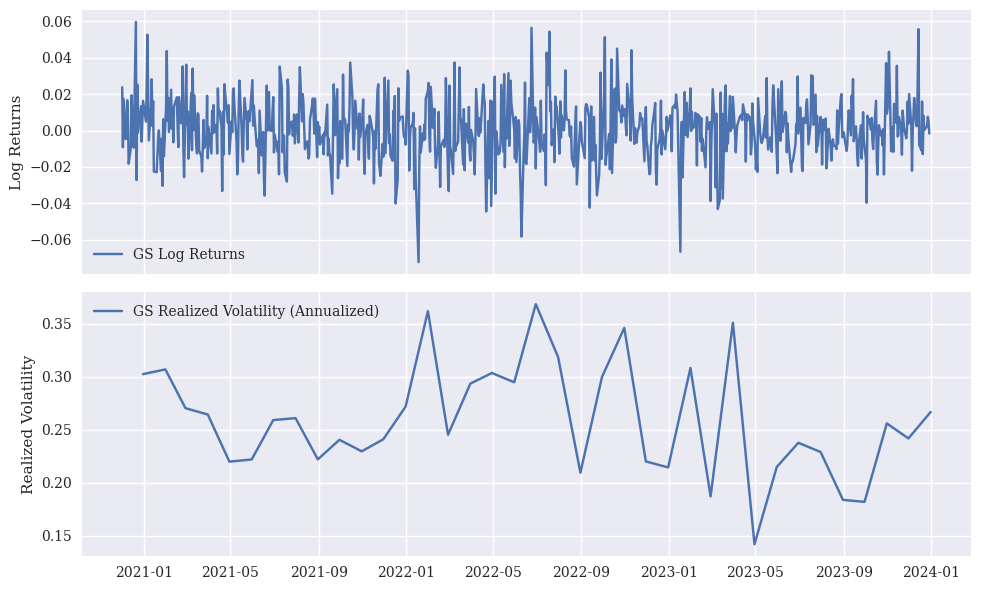

In [10]:
# Python for Finance Approach
# Define the function for calculating realized volatility
def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

# Calculate the realized volatility for 'GS_log_rtn'
gs_df_rv = gs_df.groupby(pd.Grouper(freq='M'))['GS_log_rtn'].apply(realized_volatility).to_frame(name='rv')

# Annualize the realized volatility
gs_df_rv['rv'] = gs_df_rv['rv'] * np.sqrt(12)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(gs_df['GS_log_rtn'], label='GS Log Returns')  
ax[1].plot(gs_df_rv['rv'], label='GS Realized Volatility (Annualized)')

# Set the labels and legends
ax[0].set_ylabel('Log Returns')
ax[1].set_ylabel('Realized Volatility')
ax[0].legend()
ax[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

### Salesforce:

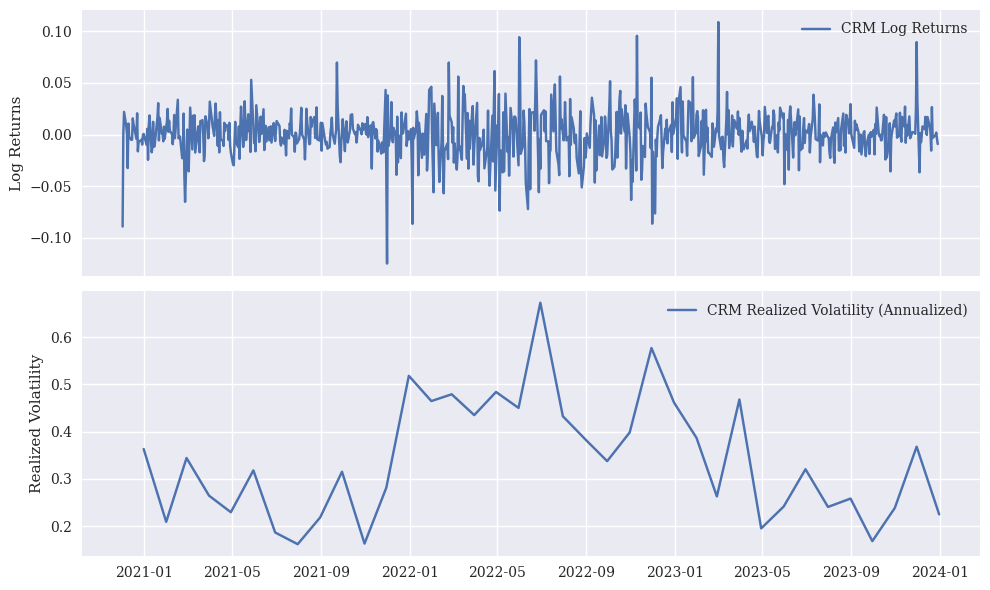

In [11]:
# Python for Finance Approach
# Define the function for calculating realized volatility
def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

# Calculate the realized volatility for 'CRM_log_rtn'
crm_df_rv = crm_df.groupby(pd.Grouper(freq='M'))['CRM_log_rtn'].apply(realized_volatility).to_frame(name='rv')

# Annualize the realized volatility
crm_df_rv['rv'] = crm_df_rv['rv'] * np.sqrt(12)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(crm_df['CRM_log_rtn'], label='CRM Log Returns')  
ax[1].plot(crm_df_rv['rv'], label='CRM Realized Volatility (Annualized)')

# Set the labels and legends
ax[0].set_ylabel('Log Returns')
ax[1].set_ylabel('Realized Volatility')
ax[0].legend()
ax[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

## Approach 2
Calculating the rolling volatility using a specified window (e.g., 30 days) and then annualizing the result by multiplying by the square root of the number of trading days in a year (usually 252 for daily data).
It directly uses the standard deviation of the returns for the rolling window.

### Goldman Sachs:

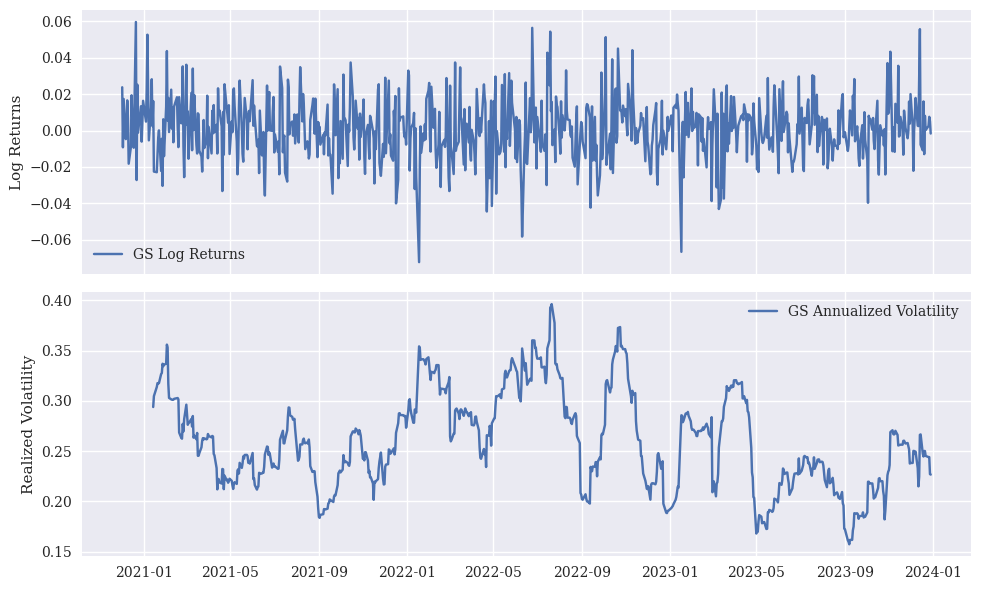

In [12]:
# Calculate the 30-day rolling volatility (standard deviation of log returns)
gs_df['GS_30Day_Rolling_Vol'] = gs_df['GS_log_rtn'].rolling(window=30).std()

# Annualize the volatility by multiplying by the square root of the number of trading days in a year
gs_df['GS_Annualized_Vol'] = gs_df['GS_30Day_Rolling_Vol'] * np.sqrt(252)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(gs_df['GS_log_rtn'], label='GS Log Returns')  
ax[1].plot(gs_df['GS_Annualized_Vol'], label='GS Annualized Volatility')
# Set the labels and legends
ax[0].set_ylabel('Log Returns')
ax[1].set_ylabel('Realized Volatility')
ax[0].legend()
ax[1].legend()
# Show the plot
plt.tight_layout()
plt.show()

### Salesforce:

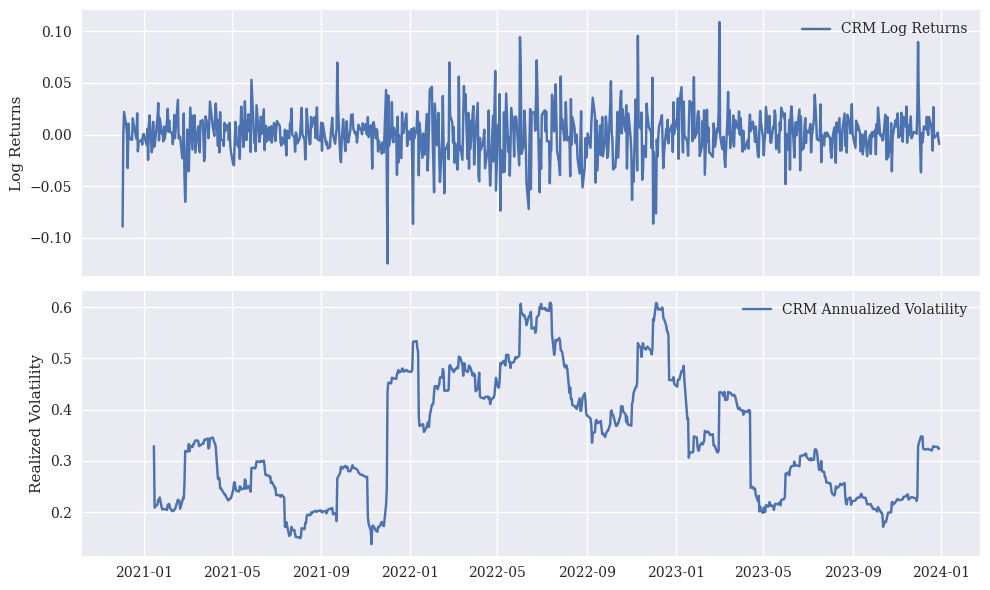

In [13]:
# Calculate the 30-day rolling volatility (standard deviation of log returns)
crm_df['CRM_30Day_Rolling_Vol'] = crm_df['CRM_log_rtn'].rolling(window=30).std()

# Annualize the volatility by multiplying by the square root of the number of trading days in a year
crm_df['CRM_Annualized_Vol'] = crm_df['CRM_30Day_Rolling_Vol'] * np.sqrt(252)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(crm_df['CRM_log_rtn'], label='CRM Log Returns')  
ax[1].plot(crm_df['CRM_Annualized_Vol'], label='CRM Annualized Volatility')
# Set the labels and legends
ax[0].set_ylabel('Log Returns')
ax[1].set_ylabel('Realized Volatility')
ax[0].legend()
ax[1].legend()
# Show the plot
plt.tight_layout()
plt.show()

# Visualising the Time Series
Plotting method using Pandas. Modified using the Python for Finance Cookbook.

### Goldman Sachs Time Series Data:

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Log returns (%)')]

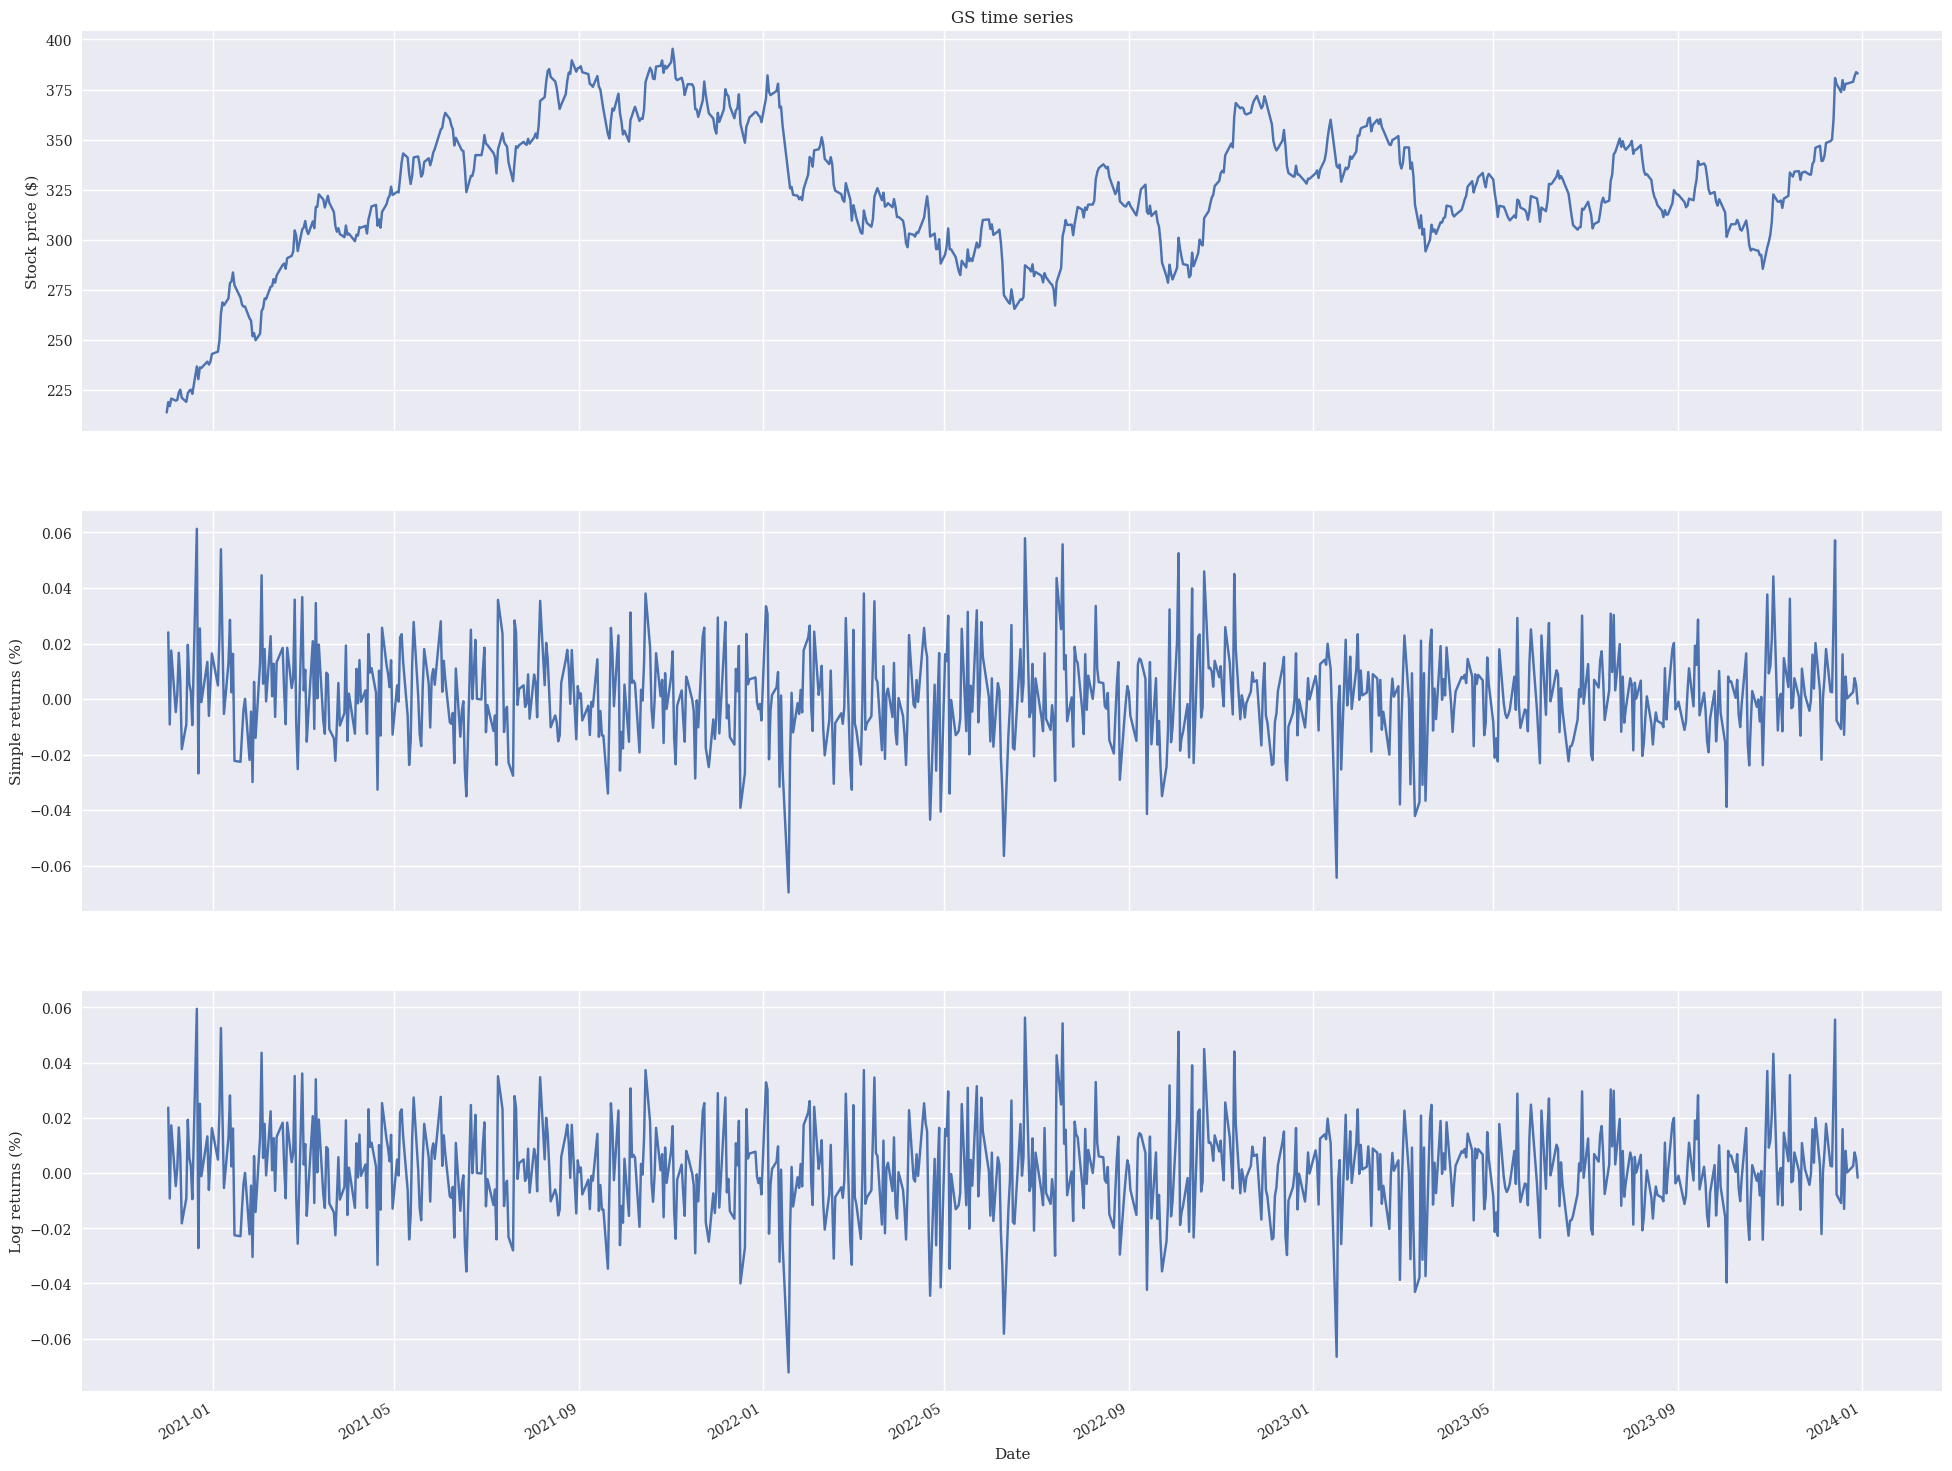

In [14]:
#Plotting GS
fig, ax = plt.subplots(3, 1, figsize=(24, 20), sharex=True)
#plotting GS firstly
gs_df.GS_adj_close.plot(ax=ax[0])
ax[0].set(title = 'GS time series',
ylabel = 'Stock price ($)')
gs_df.GS_simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')
gs_df.GS_log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date',
ylabel = 'Log returns (%)')

### Salesforce Time Series Data:

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Log returns (%)')]

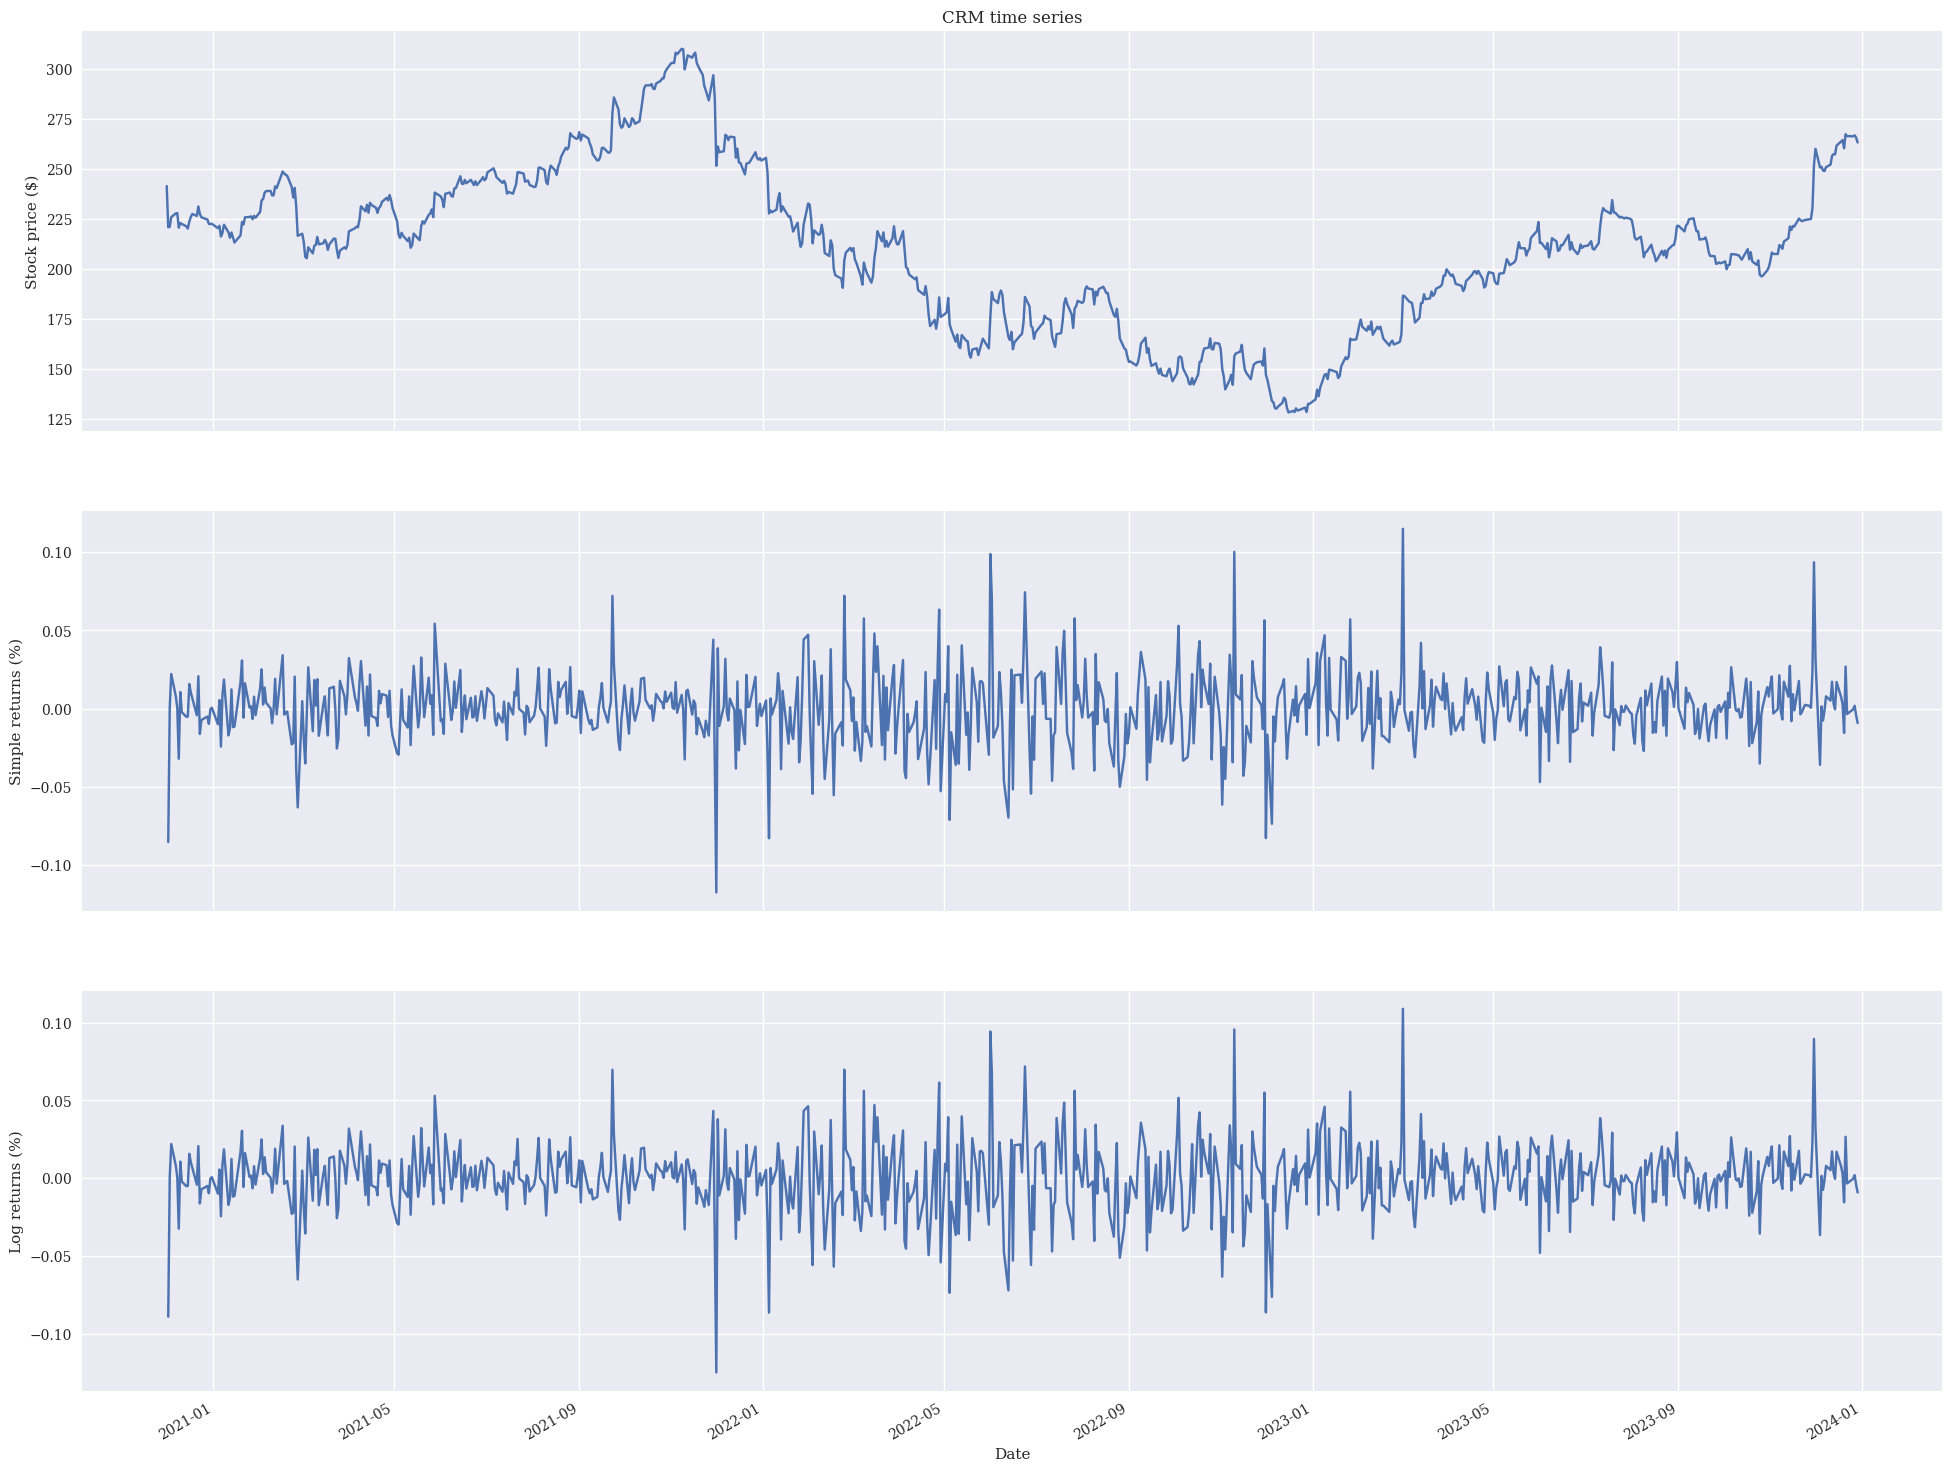

In [15]:
#Plotting Salesforce
fig, ax = plt.subplots(3, 1, figsize=(24, 20), sharex=True)
#plotting CRM Second
crm_df.CRM_adj_close.plot(ax=ax[0])
ax[0].set(title = 'CRM time series',
ylabel = 'Stock price ($)')
crm_df.CRM_simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')
crm_df.CRM_log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date',
ylabel = 'Log returns (%)')

## Structuring the Inputs and the Outputs
The length of 𝐿 is unknown. I must select 𝐿 as 5, 10, 15, 20, or 40 days in the investigation and conclude with a best 𝐿 . Please decide by yourself what lengths 𝐿 to select in your coursework

In [16]:
# Goldman Sachs using the 30 Day Rolling Volatility
# Function to structure data into sequences of L days for input and one day for output
def structure_sequences(df, L):
    input_sequences = []
    output_values = []
    
    for i in range(len(df) - L):
        input_seq = df['GS_30Day_Rolling_Vol'].iloc[i:i+L].values
        output_val = df['GS_30Day_Rolling_Vol'].iloc[i+L]
        
        input_sequences.append(input_seq)
        output_values.append(output_val)
    
    return np.array(input_sequences), np.array(output_values)

# Usage L = 5
L = 5  # Length of the input sequences
gs_inputs_L5, gs_outputs_L5 = structure_sequences(gs_df, L)

# Usage L = 10
L = 10  # Length of the input sequences
gs_inputs_L10, gs_outputs_L10 = structure_sequences(gs_df, L)


# Usage L = 15
L = 15  # Length of the input sequences
gs_inputs_L15, gs_outputs_L15 = structure_sequences(gs_df, L)


# Usage L = 20
L = 20  # Length of the input sequences
gs_inputs_L20, gs_outputs_L20 = structure_sequences(gs_df, L)


# Usage L = 40
L = 40  # Length of the input sequences
gs_inputs_L40, gs_outputs_L40 = structure_sequences(gs_df, L)

gs_inputs_L40[:1], gs_outputs_L40[:2]  # Display the first 2 samples for verification


(array([[   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan, 0.0185, 0.0192,
         0.0198, 0.02  , 0.02  , 0.02  , 0.0206, 0.0206, 0.0212, 0.0211]]),
 array([0.0212, 0.0212]))

In [17]:
# Salesforce using the 30 Day Rolling Volatility
# Function to structure data into sequences of L days for input and one day for output
def structure_sequences(df, L):
    input_sequences = []
    output_values = []
    
    for i in range(len(df) - L):
        input_seq = df['CRM_30Day_Rolling_Vol'].iloc[i:i+L].values
        output_val = df['CRM_30Day_Rolling_Vol'].iloc[i+L]
        
        input_sequences.append(input_seq)
        output_values.append(output_val)
    
    return np.array(input_sequences), np.array(output_values)

# Usage L = 5
L = 5  # Length of the input sequences
crm_inputs_L5, crm_outputs_L5 = structure_sequences(crm_df, L)

# Usage L = 10
L = 10  # Length of the input sequences
crm_inputs_L10, crm_outputs_L10 = structure_sequences(crm_df, L)


# Usage L = 15
L = 15  # Length of the input sequences
crm_inputs_L15, crm_outputs_L15 = structure_sequences(crm_df, L)


# Usage L = 20
L = 20  # Length of the input sequences
crm_inputs_L20, crm_outputs_L20 = structure_sequences(crm_df, L)


# Usage L = 40
L = 40  # Length of the input sequences
crm_inputs_L40, crm_outputs_L40 = structure_sequences(crm_df, L)

crm_inputs_L40[:1], crm_outputs_L40[:2]  # Display the first 2 samples for verification


(array([[   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan, 0.0207, 0.0132,
         0.0136, 0.0141, 0.0141, 0.0144, 0.0131, 0.0129, 0.013 , 0.013 ]]),
 array([0.013 , 0.0129]))

## Splitting the data and Normalizing
The next step after structuring the data is to split the datasets into Training and Testing sets. After splitting the data I am normalizing the data in order for the models to learn more effectively. 

In [18]:
#Goldman Sachs

# L=5 days scenario
# Split into training and testing sets (20% test size)
X_train_gs_L5, X_test_gs_L5, y_train_gs_L5, y_test_gs_L5 = train_test_split(gs_inputs_L5, gs_outputs_L5, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled_gs_L5 = scaler.fit_transform(X_train_gs_L5)

# Transform the test data with the same scaler
X_test_scaled_gs_L5 = scaler.transform(X_test_gs_L5)

#*******************************************************
# L=10 days scenario
# Split into training and testing sets (20% test size)
X_train_gs_L10, X_test_gs_L10, y_train_gs_L10, y_test_gs_L10 = train_test_split(gs_inputs_L10, gs_outputs_L10, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled_gs_L10 = scaler.fit_transform(X_train_gs_L10)

# Transform the test data with the same scaler
X_test_scaled_gs_L10 = scaler.transform(X_test_gs_L10)

#*******************************************************
# L=15 days scenario
# Split into training and testing sets (20% test size)
X_train_gs_L15, X_test_gs_L15, y_train_gs_L15, y_test_gs_L15 = train_test_split(gs_inputs_L15, gs_outputs_L15, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled_gs_L15 = scaler.fit_transform(X_train_gs_L15)

# Transform the test data with the same scaler
X_test_scaled_gs_L15 = scaler.transform(X_test_gs_L15)

#*******************************************************
# L=20 days scenario
# Split into training and testing sets (20% test size)
X_train_gs_L20, X_test_gs_L20, y_train_gs_L20, y_test_gs_L20 = train_test_split(gs_inputs_L20, gs_outputs_L20, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled_gs_L20 = scaler.fit_transform(X_train_gs_L20)

# Transform the test data with the same scaler
X_test_scaled_gs_L20 = scaler.transform(X_test_gs_L20)

#*******************************************************
# L=40 days scenario
# Split into training and testing sets (20% test size)
X_train_gs_L40, X_test_gs_L40, y_train_gs_L40, y_test_gs_L40 = train_test_split(gs_inputs_L40, gs_outputs_L40, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled_gs_L40 = scaler.fit_transform(X_train_gs_L40)

# Transform the test data with the same scaler
X_test_scaled_gs_L40 = scaler.transform(X_test_gs_L40)


In [19]:
# Salesforce

# L=5 days scenario
# Split into training and testing sets (20% test size)
X_train_crm_L5, X_test_crm_L5, y_train_crm_L5, y_test_crm_L5 = train_test_split(crm_inputs_L5, crm_outputs_L5, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled_crm_L5 = scaler.fit_transform(X_train_crm_L5)

# Transform the test data with the same scaler
X_test_scaled_crm_L5 = scaler.transform(X_test_crm_L5)

#*******************************************************
# L=10 days scenario
# Split into training and testing sets (20% test size)
X_train_crm_L10, X_test_crm_L10, y_train_crm_L10, y_test_crm_L10 = train_test_split(crm_inputs_L10, crm_outputs_L10, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled_crm_L10 = scaler.fit_transform(X_train_crm_L10)

# Transform the test data with the same scaler
X_test_scaled_crm_L10 = scaler.transform(X_test_crm_L10)

#*******************************************************
# L=15 days scenario
# Split into training and testing sets (20% test size)
X_train_crm_L15, X_test_crm_L15, y_train_crm_L15, y_test_crm_L15 = train_test_split(crm_inputs_L15, crm_outputs_L15, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled_crm_L15 = scaler.fit_transform(X_train_crm_L15)

# Transform the test data with the same scaler
X_test_scaled_crm_L15 = scaler.transform(X_test_crm_L15)

#*******************************************************
# L=20 days scenario
# Split into training and testing sets (20% test size)
X_train_crm_L20, X_test_crm_L20, y_train_crm_L20, y_test_crm_L20 = train_test_split(crm_inputs_L20, crm_outputs_L20, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled_crm_L20 = scaler.fit_transform(X_train_crm_L20)

# Transform the test data with the same scaler
X_test_scaled_crm_L20 = scaler.transform(X_test_crm_L20)

#*******************************************************
# L=40 days scenario
# Split into training and testing sets (20% test size)
X_train_crm_L40, X_test_crm_L40, y_train_crm_L40, y_test_crm_L40 = train_test_split(crm_inputs_L40, crm_outputs_L40, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled_crm_L40 = scaler.fit_transform(X_train_crm_L40)

# Transform the test data with the same scaler
X_test_scaled_crm_L40 = scaler.transform(X_test_crm_L40)

# Model Implementation

## Model 1 - Recurring Neural Network (RNN). 

## 1.1 - Goldman Sachs where L = 5
The first Model will run through the Goldman Sachs Stock where L=5

### Defining the Recurring Neural Network Model. 

In [20]:
# Importing the various libraries for TensorFlow framework used for RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

In [21]:
def build_rnn_model(input_shape):
    model = Sequential()
    # RNN layer
    model.add(SimpleRNN(units=50, activation='relu', return_sequences=False, input_shape=input_shape))
    # Output layer to predict future volatility
    model.add(Dense(units=1))
    
    return model

### Compile the Model

In [22]:
model = build_rnn_model(input_shape=(5, 1)) # L is the length of input sequences and I have 1 feature
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train the Model

In [24]:
# Reshaping the input in order for train the model
X_train_reshaped_gs_L5 = X_train_scaled_gs_L5.reshape((X_train_scaled_gs_L5.shape[0], 5, 1))
X_test_reshaped_gs_L5 = X_test_scaled_gs_L5.reshape((X_test_scaled_gs_L5.shape[0], 5, 1))


In [25]:
# Check for NaNs and handle them

# Example for handling NaNs
X_train_reshaped_gs_L5 = np.nan_to_num(X_train_reshaped_gs_L5)
X_test_reshaped_gs_L5 = np.nan_to_num(X_test_reshaped_gs_L5)
y_train_gs_L5 = np.nan_to_num(y_train_gs_L5)
y_test_gs_L5 = np.nan_to_num(y_test_gs_L5)


# L=5 days scenario for GS
history = model.fit(X_train_reshaped_gs_L5, y_train_gs_L5, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
16/16 [==============================] - 2s 39ms/step - loss: 0.0634 - val_loss: 0.0119
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0047 - val_loss: 0.0034
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 8.5481e-04 - val_loss: 0.0011
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 5.5103e-04 - val_loss: 8.1758e-04
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 3.9354e-04 - val_loss: 7.0975e-04
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 3.1012e-04 - val_loss: 6.6391e-04
Epoch 8/100
16/16 [==============================] - 0s 13ms/step - loss: 2.4129e-04 - val_loss: 5.6662e-04
Epoch 9/100
16/16 [==============================] - 0s 10ms/step - loss: 1.8700e-04 - val_loss: 5.3326e-04
Epoch 10/100
16/16 [==============================] - 0s

Epoch 77/100
16/16 [==============================] - 0s 8ms/step - loss: 2.0901e-05 - val_loss: 1.0954e-04
Epoch 78/100
16/16 [==============================] - 0s 8ms/step - loss: 3.7476e-05 - val_loss: 8.8465e-05
Epoch 79/100
16/16 [==============================] - 0s 9ms/step - loss: 3.0959e-05 - val_loss: 8.9263e-05
Epoch 80/100
16/16 [==============================] - 0s 8ms/step - loss: 1.3470e-05 - val_loss: 8.1608e-05
Epoch 81/100
16/16 [==============================] - 0s 14ms/step - loss: 1.4429e-05 - val_loss: 8.5821e-05
Epoch 82/100
16/16 [==============================] - 0s 10ms/step - loss: 1.8333e-05 - val_loss: 8.9100e-05
Epoch 83/100
16/16 [==============================] - 0s 8ms/step - loss: 1.7988e-05 - val_loss: 9.8856e-05
Epoch 84/100
16/16 [==============================] - 0s 9ms/step - loss: 1.5489e-05 - val_loss: 8.9174e-05
Epoch 85/100
16/16 [==============================] - 0s 8ms/step - loss: 1.2314e-05 - val_loss: 7.9137e-05
Epoch 86/100
16/16 [======

### Evaluate the Model

In [26]:
test_loss = model.evaluate(X_test_reshaped_gs_L5, y_test_gs_L5)
print(f"Test Loss: {test_loss}")

5/5 [==============================] - 0s 3ms/step - loss: 2.3860e-05
Test Loss: 2.386006963206455e-05


### Make Predictions

In [27]:
predictions = model.predict(X_test_reshaped_gs_L5)
print(predictions)

5/5 [==============================] - 0s 3ms/step
[[0.0161]
 [0.0184]
 [0.0064]
 [0.0201]
 [0.0184]
 [0.0199]
 [0.0179]
 [0.0199]
 [0.0041]
 [0.0188]
 [0.0139]
 [0.0145]
 [0.0138]
 [0.0192]
 [0.0139]
 [0.0136]
 [0.0168]
 [0.0156]
 [0.0173]
 [0.0113]
 [0.0213]
 [0.0174]
 [0.0269]
 [0.0139]
 [0.006 ]
 [0.021 ]
 [0.0186]
 [0.0163]
 [0.0184]
 [0.0088]
 [0.0161]
 [0.0102]
 [0.0148]
 [0.021 ]
 [0.0089]
 [0.0117]
 [0.0201]
 [0.0262]
 [0.0207]
 [0.0202]
 [0.0193]
 [0.0273]
 [0.02  ]
 [0.0104]
 [0.0206]
 [0.0201]
 [0.0276]
 [0.0168]
 [0.0232]
 [0.0132]
 [0.0166]
 [0.0219]
 [0.0117]
 [0.0203]
 [0.0134]
 [0.0195]
 [0.0204]
 [0.0203]
 [0.012 ]
 [0.0262]
 [0.0144]
 [0.0195]
 [0.0144]
 [0.0155]
 [0.0126]
 [0.0152]
 [0.0154]
 [0.0141]
 [0.0131]
 [0.0173]
 [0.0185]
 [0.0155]
 [0.0057]
 [0.02  ]
 [0.0205]
 [0.0212]
 [0.0168]
 [0.0374]
 [0.0257]
 [0.0033]
 [0.0127]
 [0.0115]
 [0.0148]
 [0.021 ]
 [0.0131]
 [0.0176]
 [0.018 ]
 [0.0202]
 [0.0148]
 [0.0097]
 [0.0152]
 [0.0204]
 [0.02  ]
 [0.0131]
 [0.019 ]

### Visualise the Outputs

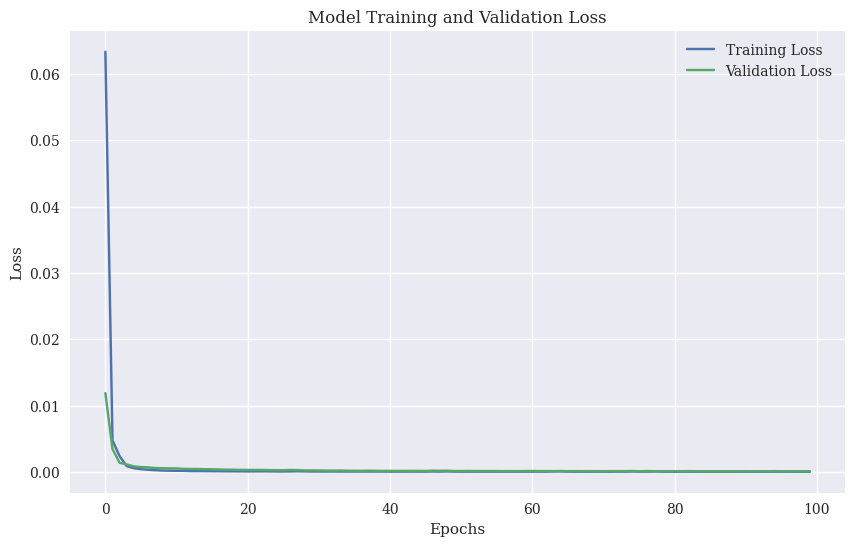

In [28]:
import matplotlib.pyplot as plt

# Plotting training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# This plot is essential for understanding how the model learns over time. The training loss should generally decrease
# as the model gets better at making predictions on the training data. The validation loss gives an indication of how well
# the model generalizes to unseen data. If the validation loss decreases alongside the training loss, it suggests good generalization.
# If the validation loss begins to increase while training loss continues to decrease, this could indicate overfitting.


Mean Absolute Error (MAE): 0.002937003450110668
Mean Squared Error (MSE): 2.3860082513510156e-05
Root Mean Squared Error (RMSE): 0.004884678342891183


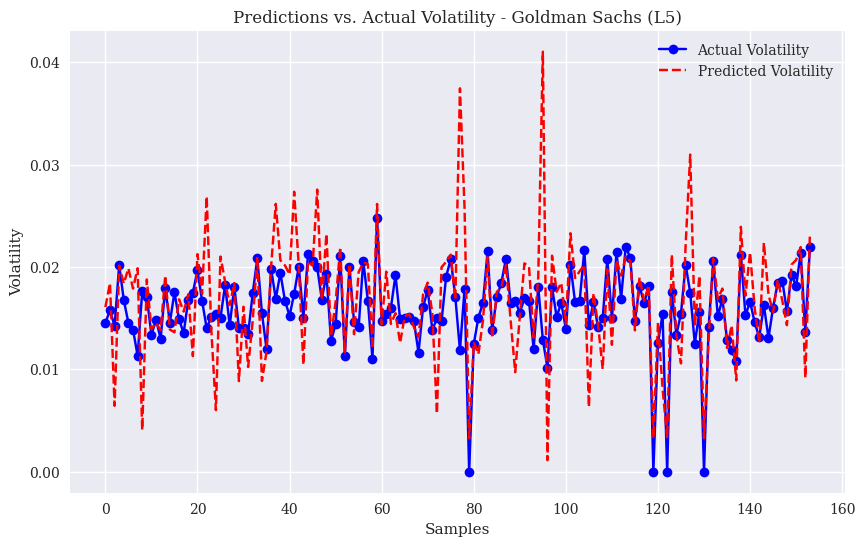

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test_gs_L5, predictions)
mse = mean_squared_error(y_test_gs_L5, predictions)
rmse = mse ** 0.5  # Square root of MSE

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting Predictions vs Actual Data
plt.figure(figsize=(10, 6))
plt.plot(y_test_gs_L5, label='Actual Volatility', color='blue', marker='o')
plt.plot(predictions, label='Predicted Volatility', color='red', linestyle='--', marker='x')
plt.title('Predictions vs. Actual Volatility - Goldman Sachs (L5)')
plt.xlabel('Samples')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# The plot and metrics provide a visual and quantitative assessment of the model's performance. The closer the predictions are to the actual values, the better the model. Differences between the predicted and actual values indicate prediction errors. The metrics quantify these errors, with lower values indicating better model performance.


## 1.2 - Salesforce where L = 5
I can use the model created in the previous steps by reshaping the CRM data so that it fits the model. 

### Train the Model

In [30]:
# Reshaping the input in order for train the model
X_train_reshaped_crm_L5 = X_train_scaled_crm_L5.reshape((X_train_scaled_crm_L5.shape[0], 5, 1))
X_test_reshaped_crm_L5 = X_test_scaled_crm_L5.reshape((X_test_scaled_crm_L5.shape[0], 5, 1))

# Check for NaNs and handle them

# Example for handling NaNs
X_train_reshaped_crm_L5 = np.nan_to_num(X_train_reshaped_crm_L5)
X_test_reshaped_crm_L5 = np.nan_to_num(X_test_reshaped_crm_L5)
y_train_crm_L5 = np.nan_to_num(y_train_crm_L5)
y_test_crm_L5 = np.nan_to_num(y_test_crm_L5)


# L=5 days scenario for CRM
history = model.fit(X_train_reshaped_crm_L5, y_train_crm_L5, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
16/16 [==============================] - 0s 17ms/step - loss: 1.0237e-04 - val_loss: 8.3373e-05
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 2.3141e-05 - val_loss: 9.0353e-05
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 1.4488e-05 - val_loss: 7.4085e-05
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 1.0573e-05 - val_loss: 6.8835e-05
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 8.5242e-06 - val_loss: 7.0277e-05
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 7.6649e-06 - val_loss: 6.9572e-05
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 7.1305e-06 - val_loss: 7.0510e-05
Epoch 8/100
16/16 [==============================] - 0s 8ms/step - loss: 6.5145e-06 - val_loss: 7.5399e-05
Epoch 9/100
16/16 [==============================] - 0s 11ms/step - loss: 7.0825e-06 - val_loss: 7.2173e-05
Epoch 10/100
16/16 [==============

16/16 [==============================] - 0s 8ms/step - loss: 4.3953e-06 - val_loss: 7.3202e-05
Epoch 77/100
16/16 [==============================] - 0s 9ms/step - loss: 3.4524e-06 - val_loss: 7.1466e-05
Epoch 78/100
16/16 [==============================] - 0s 9ms/step - loss: 4.1376e-06 - val_loss: 7.3143e-05
Epoch 79/100
16/16 [==============================] - 0s 8ms/step - loss: 5.8333e-06 - val_loss: 7.2572e-05
Epoch 80/100
16/16 [==============================] - 0s 7ms/step - loss: 4.5632e-06 - val_loss: 7.1875e-05
Epoch 81/100
16/16 [==============================] - 0s 6ms/step - loss: 3.7388e-06 - val_loss: 7.0476e-05
Epoch 82/100
16/16 [==============================] - 0s 7ms/step - loss: 3.6196e-06 - val_loss: 7.1929e-05
Epoch 83/100
16/16 [==============================] - 0s 9ms/step - loss: 4.3957e-06 - val_loss: 7.8540e-05
Epoch 84/100
16/16 [==============================] - 0s 8ms/step - loss: 8.3181e-06 - val_loss: 8.7998e-05
Epoch 85/100
16/16 [=====================

### Evaluate the Model 

In [31]:
test_loss = model.evaluate(X_test_reshaped_crm_L5, y_test_crm_L5)
print(f"Test Loss: {test_loss}")

5/5 [==============================] - 0s 4ms/step - loss: 2.9740e-05
Test Loss: 2.9739856472588144e-05


### Make Prediction

In [32]:
predictions = model.predict(X_test_reshaped_crm_L5)
print(predictions)

5/5 [==============================] - 0s 5ms/step
[[ 0.015 ]
 [ 0.0228]
 [ 0.014 ]
 [ 0.0247]
 [ 0.0147]
 [ 0.0202]
 [ 0.0146]
 [ 0.0135]
 [ 0.0262]
 [ 0.0146]
 [ 0.0317]
 [ 0.0185]
 [ 0.0117]
 [ 0.0306]
 [ 0.0143]
 [ 0.032 ]
 [ 0.0158]
 [ 0.0198]
 [ 0.0251]
 [ 0.0267]
 [ 0.027 ]
 [ 0.0276]
 [ 0.0096]
 [ 0.0185]
 [ 0.0315]
 [ 0.0179]
 [ 0.0306]
 [ 0.0229]
 [ 0.0295]
 [ 0.0119]
 [ 0.0159]
 [ 0.0103]
 [ 0.0252]
 [ 0.0274]
 [ 0.0187]
 [ 0.0138]
 [ 0.0271]
 [ 0.0213]
 [ 0.0248]
 [ 0.0198]
 [ 0.0178]
 [ 0.0256]
 [ 0.0167]
 [ 0.0241]
 [ 0.0119]
 [ 0.0146]
 [ 0.0142]
 [ 0.0167]
 [ 0.0281]
 [ 0.0137]
 [ 0.02  ]
 [ 0.0361]
 [ 0.0143]
 [ 0.0254]
 [ 0.0365]
 [ 0.0154]
 [ 0.0322]
 [ 0.024 ]
 [ 0.0149]
 [ 0.0265]
 [ 0.0198]
 [ 0.0215]
 [ 0.0277]
 [ 0.0318]
 [ 0.0007]
 [ 0.018 ]
 [ 0.0192]
 [ 0.0199]
 [ 0.0134]
 [ 0.0149]
 [ 0.0164]
 [ 0.0133]
 [ 0.0346]
 [ 0.0156]
 [ 0.025 ]
 [ 0.0306]
 [ 0.0144]
 [ 0.0306]
 [ 0.0238]
 [ 0.0038]
 [ 0.0135]
 [ 0.0248]
 [ 0.0124]
 [ 0.0343]
 [ 0.0128]
 [ 0.0284]
 [ 

### Visualise the Outputs

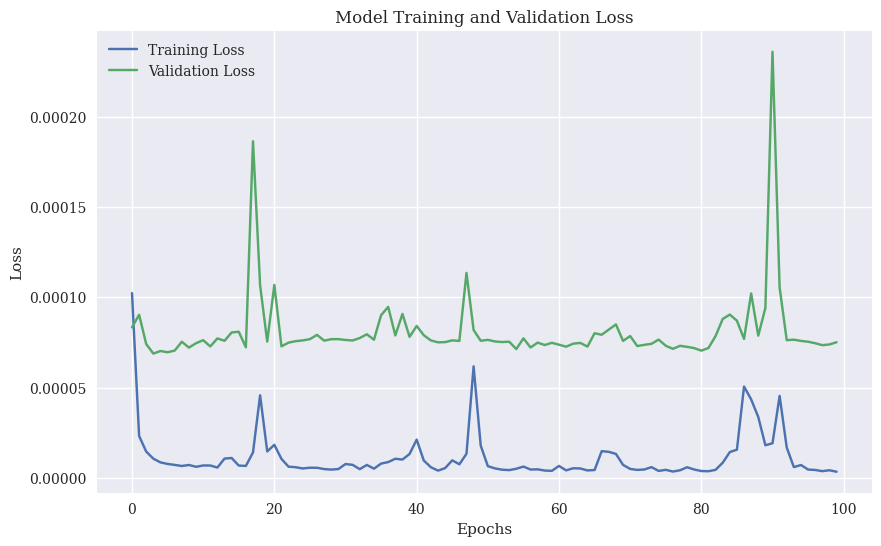

In [33]:
import matplotlib.pyplot as plt

# Plotting training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# This plot is essential for understanding how the model learns over time. The training loss should generally decrease
# as the model gets better at making predictions on the training data. The validation loss gives an indication of how well
# the model generalizes to unseen data. If the validation loss decreases alongside the training loss, it suggests good generalization.
# If the validation loss begins to increase while training loss continues to decrease, this could indicate overfitting.



Mean Absolute Error (MAE): 0.002369154235098671
Mean Squared Error (MSE): 2.973983997075991e-05
Root Mean Squared Error (RMSE): 0.005453424609432124


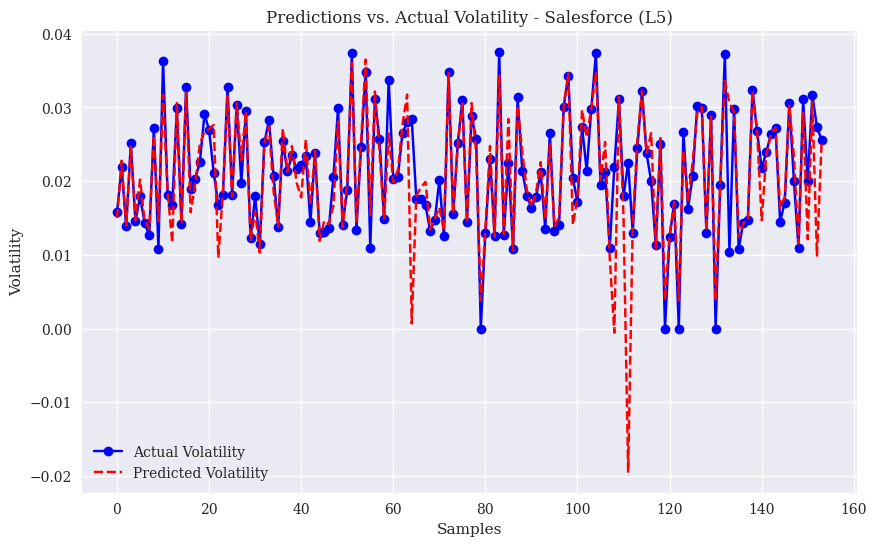

In [34]:
# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test_crm_L5, predictions)
mse = mean_squared_error(y_test_crm_L5, predictions)
rmse = mse ** 0.5  # Square root of MSE

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting Predictions vs Actual Data
plt.figure(figsize=(10, 6))
plt.plot(y_test_crm_L5, label='Actual Volatility', color='blue', marker='o')
plt.plot(predictions, label='Predicted Volatility', color='red', linestyle='--', marker='x')
plt.title('Predictions vs. Actual Volatility - Salesforce (L5)')
plt.xlabel('Samples')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# The plot and metrics provide a visual and quantitative assessment of the model's performance. The closer the predictions are to the actual values, the better the model. Differences between the predicted and actual values indicate prediction errors. The metrics quantify these errors, with lower values indicating better model performance.



## 1.3 - Salesforce where L = 10
### Compile the Model

In [35]:
model = build_rnn_model(input_shape=(10, 1))  # L is the length of input sequences and I have 1 feature

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

### Train the Model

In [36]:
# Reshaping the input in order for train the model
X_train_reshaped_crm_L10 = X_train_scaled_crm_L10.reshape((X_train_scaled_crm_L10.shape[0], 10, 1))
X_test_reshaped_crm_L10 = X_test_scaled_crm_L10.reshape((X_test_scaled_crm_L10.shape[0], 10, 1))

# Check for NaNs and handle them

# Example for handling NaNs
X_train_reshaped_crm_L10 = np.nan_to_num(X_train_reshaped_crm_L10)
X_test_reshaped_crm_L10 = np.nan_to_num(X_test_reshaped_crm_L10)
y_train_crm_L10 = np.nan_to_num(y_train_crm_L10)
y_test_crm_L10 = np.nan_to_num(y_test_crm_L10)


# L=10 days scenario for CRM
history = model.fit(X_train_reshaped_crm_L10, y_train_crm_L10, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
16/16 [==============================] - 2s 31ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 5.8049e-04 - val_loss: 8.3114e-04
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 2.9298e-04 - val_loss: 5.2247e-04
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 1.7535e-04 - val_loss: 4.5266e-04
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 1.4742e-04 - val_loss: 3.6734e-04
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 1.5170e-04 - val_loss: 3.4526e-04
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 9.9580e-05 - val_loss: 2.8379e-04
Epoch 8/100
16/16 [==============================] - 0s 13ms/step - loss: 7.5603e-05 - val_loss: 2.2903e-04
Epoch 9/100
16/16 [==============================] - 0s 9ms/step - loss: 7.2657e-05 - val_loss: 2.1719e-04
Epoch 10/100
16/16 [==================

16/16 [==============================] - 0s 10ms/step - loss: 8.2642e-06 - val_loss: 6.3225e-05
Epoch 77/100
16/16 [==============================] - 0s 11ms/step - loss: 5.4065e-06 - val_loss: 6.0040e-05
Epoch 78/100
16/16 [==============================] - 0s 9ms/step - loss: 6.0433e-06 - val_loss: 6.5621e-05
Epoch 79/100
16/16 [==============================] - 0s 9ms/step - loss: 1.2362e-05 - val_loss: 6.7419e-05
Epoch 80/100
16/16 [==============================] - 0s 9ms/step - loss: 1.3004e-05 - val_loss: 6.6563e-05
Epoch 81/100
16/16 [==============================] - 0s 10ms/step - loss: 1.1677e-05 - val_loss: 1.1813e-04
Epoch 82/100
16/16 [==============================] - 0s 9ms/step - loss: 2.1639e-05 - val_loss: 6.6421e-05
Epoch 83/100
16/16 [==============================] - 0s 10ms/step - loss: 7.6279e-06 - val_loss: 6.5728e-05
Epoch 84/100
16/16 [==============================] - 0s 9ms/step - loss: 7.5070e-06 - val_loss: 6.7694e-05
Epoch 85/100
16/16 [=================

### Evaluate the Model

In [37]:
test_loss = model.evaluate(X_test_reshaped_crm_L10, y_test_crm_L10)
print(f"Test Loss: {test_loss}")

5/5 [==============================] - 0s 6ms/step - loss: 5.6355e-05
Test Loss: 5.635474735754542e-05


### Make the Prediction

In [38]:
predictions = model.predict(X_test_reshaped_crm_L10)
print(predictions)

5/5 [==============================] - 0s 5ms/step
[[0.0325]
 [0.0284]
 [0.0182]
 [0.0118]
 [0.0262]
 [0.0623]
 [0.0146]
 [0.0143]
 [0.0189]
 [0.0165]
 [0.0179]
 [0.0214]
 [0.0292]
 [0.0106]
 [0.0349]
 [0.0152]
 [0.0247]
 [0.0186]
 [0.0265]
 [0.0344]
 [0.0239]
 [0.0196]
 [0.0124]
 [0.0158]
 [0.0266]
 [0.0126]
 [0.0047]
 [0.0391]
 [0.0122]
 [0.03  ]
 [0.0181]
 [0.0118]
 [0.0179]
 [0.0234]
 [0.02  ]
 [0.0126]
 [0.034 ]
 [0.0129]
 [0.0126]
 [0.047 ]
 [0.0137]
 [0.032 ]
 [0.0123]
 [0.0238]
 [0.0248]
 [0.0281]
 [0.0273]
 [0.0098]
 [0.0249]
 [0.0245]
 [0.0177]
 [0.0177]
 [0.0184]
 [0.0165]
 [0.0128]
 [0.0119]
 [0.0135]
 [0.0101]
 [0.0101]
 [0.0125]
 [0.0147]
 [0.0182]
 [0.0366]
 [0.0247]
 [0.012 ]
 [0.0151]
 [0.0307]
 [0.0197]
 [0.0161]
 [0.0139]
 [0.0262]
 [0.0263]
 [0.0004]
 [0.0116]
 [0.028 ]
 [0.0122]
 [0.0137]
 [0.0234]
 [0.0193]
 [0.0287]
 [0.0131]
 [0.0202]
 [0.0181]
 [0.0497]
 [0.0169]
 [0.013 ]
 [0.0456]
 [0.0346]
 [0.0278]
 [0.0135]
 [0.0131]
 [0.0131]
 [0.0098]
 [0.0261]
 [0.0244]

### Visualise the Outputs

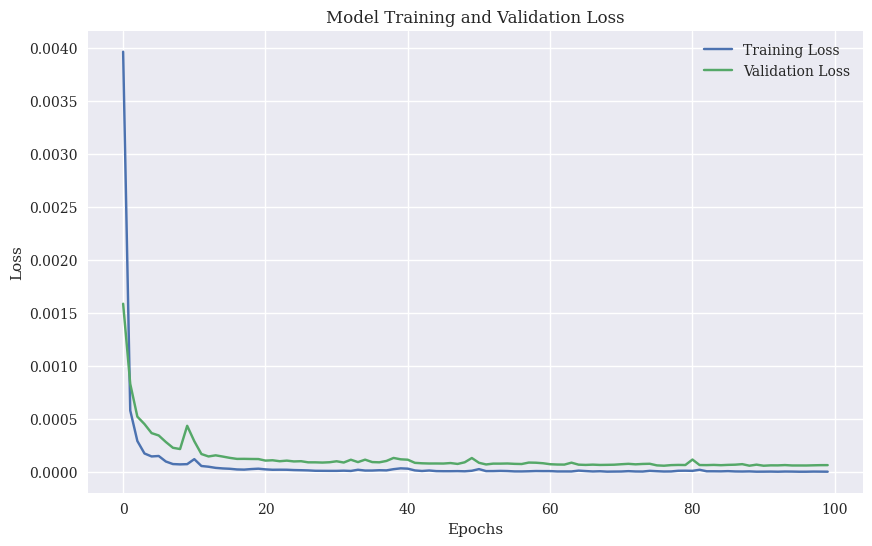

In [39]:
# Plotting training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# This plot is essential for understanding how the model learns over time. The training loss should generally decrease
# as the model gets better at making predictions on the training data. The validation loss gives an indication of how well
# the model generalizes to unseen data. If the validation loss decreases alongside the training loss, it suggests good generalization.
# If the validation loss begins to increase while training loss continues to decrease, this could indicate overfitting.




Mean Absolute Error (MAE): 0.0032093501742328423
Mean Squared Error (MSE): 5.635475412226894e-05
Root Mean Squared Error (RMSE): 0.007506980359789743


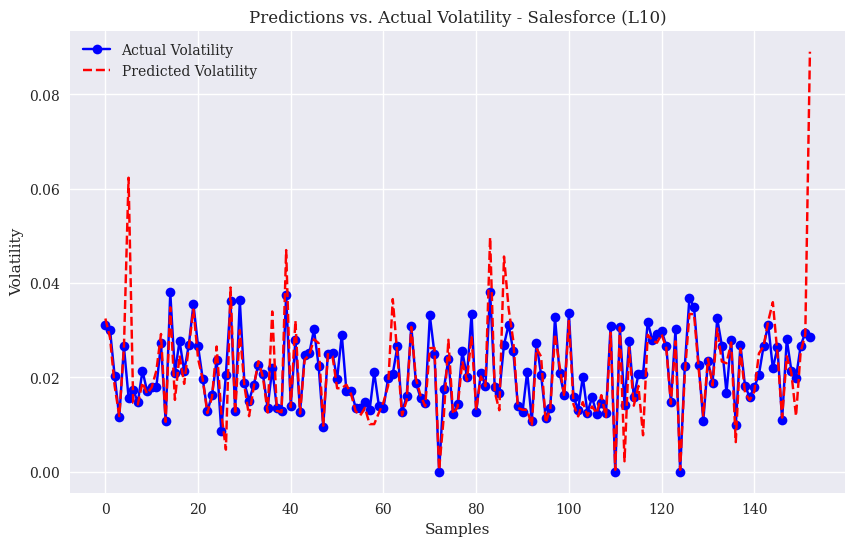

In [40]:
# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test_crm_L10, predictions)
mse = mean_squared_error(y_test_crm_L10, predictions)
rmse = mse ** 0.5  # Square root of MSE

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting Predictions vs Actual Data
plt.figure(figsize=(10, 6))
plt.plot(y_test_crm_L10, label='Actual Volatility', color='blue', marker='o')
plt.plot(predictions, label='Predicted Volatility', color='red', linestyle='--', marker='x')
plt.title('Predictions vs. Actual Volatility - Salesforce (L10)')
plt.xlabel('Samples')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# The plot and metrics provide a visual and quantitative assessment of the model's performance. The closer the predictions are to the actual values, the better the model. Differences between the predicted and actual values indicate prediction errors. The metrics quantify these errors, with lower values indicating better model performance.

Predictioin from the L10 looks to be more accurate than the L5 predictions

## 1.4 - Goldman Sachs where L = 10
### Train the Model

In [41]:
# Reshaping the input in order for train the model
X_train_reshaped_gs_L10 = X_train_scaled_gs_L10.reshape((X_train_scaled_gs_L10.shape[0], 10, 1))
X_test_reshaped_gs_L10 = X_test_scaled_gs_L10.reshape((X_test_scaled_gs_L10.shape[0], 10, 1))

# Check for NaNs and handle them

# Example for handling NaNs
X_train_reshaped_gs_L10 = np.nan_to_num(X_train_reshaped_gs_L10)
X_test_reshaped_gs_L10 = np.nan_to_num(X_test_reshaped_gs_L10)
y_train_gs_L10 = np.nan_to_num(y_train_gs_L10)
y_test_gs_L10 = np.nan_to_num(y_test_gs_L10)


# L=10 days scenario for GS
history = model.fit(X_train_reshaped_gs_L10, y_train_gs_L10, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
16/16 [==============================] - 0s 21ms/step - loss: 1.1763e-04 - val_loss: 1.5889e-04
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 8.5821e-05 - val_loss: 7.5800e-05
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 6.4177e-05 - val_loss: 6.0867e-05
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 4.7832e-05 - val_loss: 4.8656e-05
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 5.4629e-05 - val_loss: 7.9703e-05
Epoch 6/100
16/16 [==============================] - 0s 12ms/step - loss: 3.7347e-05 - val_loss: 3.7665e-05
Epoch 7/100
16/16 [==============================] - 0s 12ms/step - loss: 3.3256e-05 - val_loss: 4.6308e-05
Epoch 8/100
16/16 [==============================] - 0s 14ms/step - loss: 2.1318e-05 - val_loss: 3.6754e-05
Epoch 9/100
16/16 [==============================] - 0s 12ms/step - loss: 1.5739e-05 - val_loss: 3.5990e-05
Epoch 10/100
16/16 [========

16/16 [==============================] - 0s 12ms/step - loss: 5.4583e-06 - val_loss: 1.3962e-05
Epoch 77/100
16/16 [==============================] - 0s 12ms/step - loss: 3.6827e-06 - val_loss: 1.3339e-05
Epoch 78/100
16/16 [==============================] - 0s 14ms/step - loss: 2.5687e-06 - val_loss: 1.2578e-05
Epoch 79/100
16/16 [==============================] - 0s 15ms/step - loss: 3.0181e-06 - val_loss: 1.3582e-05
Epoch 80/100
16/16 [==============================] - 0s 15ms/step - loss: 3.1371e-06 - val_loss: 1.3425e-05
Epoch 81/100
16/16 [==============================] - 0s 12ms/step - loss: 2.4757e-06 - val_loss: 1.3311e-05
Epoch 82/100
16/16 [==============================] - 0s 13ms/step - loss: 2.5154e-06 - val_loss: 1.4458e-05
Epoch 83/100
16/16 [==============================] - 0s 10ms/step - loss: 3.1981e-06 - val_loss: 1.3060e-05
Epoch 84/100
16/16 [==============================] - 0s 17ms/step - loss: 2.4694e-06 - val_loss: 1.5360e-05
Epoch 85/100
16/16 [============

### Evaluate the Model 

In [42]:
test_loss = model.evaluate(X_test_reshaped_gs_L10, y_test_gs_L10)
print(f"Test Loss: {test_loss}")

5/5 [==============================] - 0s 6ms/step - loss: 1.2442e-05
Test Loss: 1.2441839317034464e-05


### Make the Prediction

In [43]:
predictions = model.predict(X_test_reshaped_gs_L10)
print(predictions)

5/5 [==============================] - 0s 4ms/step
[[ 0.0154]
 [ 0.0182]
 [ 0.0175]
 [ 0.0105]
 [ 0.0154]
 [ 0.0151]
 [ 0.0107]
 [ 0.012 ]
 [ 0.0187]
 [ 0.0164]
 [ 0.0143]
 [ 0.0137]
 [ 0.0158]
 [ 0.0134]
 [ 0.0174]
 [ 0.0118]
 [ 0.0149]
 [ 0.0164]
 [ 0.0227]
 [ 0.0145]
 [ 0.0168]
 [ 0.0126]
 [ 0.0091]
 [ 0.0135]
 [ 0.0175]
 [ 0.014 ]
 [ 0.0123]
 [ 0.0111]
 [ 0.0159]
 [ 0.0159]
 [ 0.0112]
 [ 0.0114]
 [ 0.0124]
 [ 0.0159]
 [ 0.0162]
 [ 0.0096]
 [ 0.016 ]
 [ 0.0206]
 [ 0.0168]
 [ 0.0122]
 [ 0.0098]
 [ 0.0162]
 [ 0.0078]
 [ 0.0163]
 [ 0.0151]
 [ 0.0207]
 [ 0.0138]
 [ 0.0168]
 [ 0.0153]
 [ 0.0154]
 [ 0.013 ]
 [ 0.0149]
 [ 0.0127]
 [ 0.0151]
 [ 0.009 ]
 [ 0.0109]
 [ 0.008 ]
 [ 0.0144]
 [ 0.0163]
 [ 0.0061]
 [ 0.0108]
 [ 0.0126]
 [ 0.0194]
 [ 0.0204]
 [ 0.0121]
 [ 0.0108]
 [ 0.0161]
 [ 0.013 ]
 [ 0.0117]
 [ 0.017 ]
 [ 0.0173]
 [ 0.0159]
 [-0.0003]
 [ 0.0112]
 [ 0.0127]
 [ 0.0112]
 [ 0.0102]
 [ 0.0153]
 [ 0.0267]
 [ 0.017 ]
 [ 0.0121]
 [ 0.0127]
 [ 0.0127]
 [ 0.017 ]
 [ 0.0216]
 [ 0.0103]
 [ 

### Visualise the Output

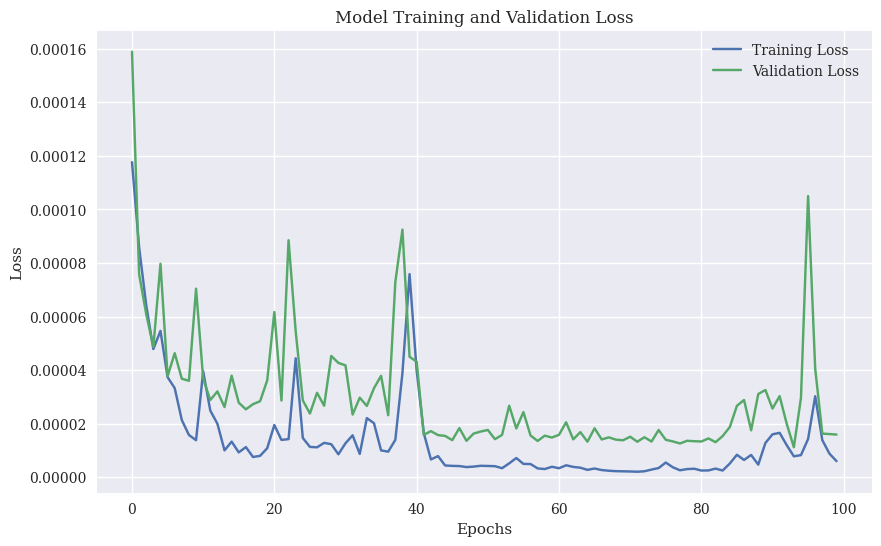

In [44]:
# Plotting training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# This plot is essential for understanding how the model learns over time. The training loss should generally decrease
# as the model gets better at making predictions on the training data. The validation loss gives an indication of how well
# the model generalizes to unseen data. If the validation loss decreases alongside the training loss, it suggests good generalization.
# If the validation loss begins to increase while training loss continues to decrease, this could indicate overfitting.

Mean Absolute Error (MAE): 0.002751573733883837
Mean Squared Error (MSE): 1.2441850039609295e-05
Root Mean Squared Error (RMSE): 0.003527300673264089


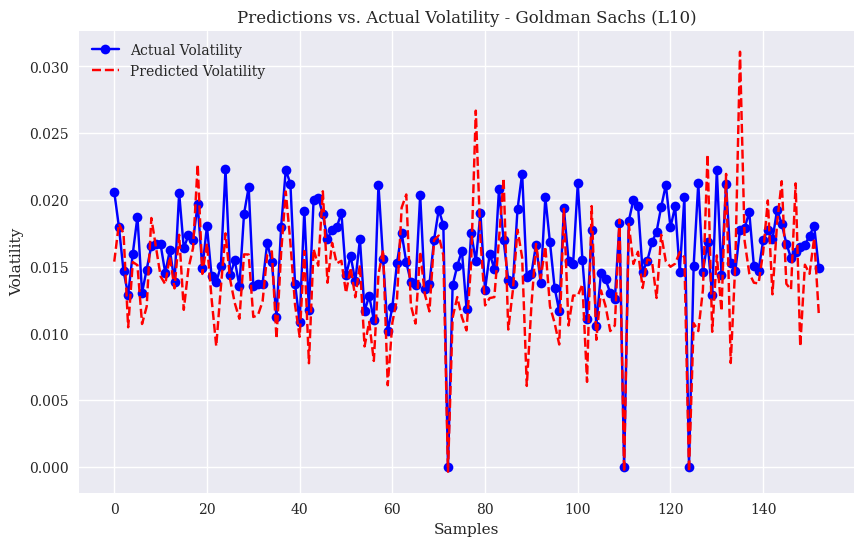

In [45]:
# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test_gs_L10, predictions)
mse = mean_squared_error(y_test_gs_L10, predictions)
rmse = mse ** 0.5  # Square root of MSE

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting Predictions vs Actual Data
plt.figure(figsize=(10, 6))
plt.plot(y_test_gs_L10, label='Actual Volatility', color='blue', marker='o')
plt.plot(predictions, label='Predicted Volatility', color='red', linestyle='--', marker='x')
plt.title('Predictions vs. Actual Volatility - Goldman Sachs (L10)')
plt.xlabel('Samples')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# The plot and metrics provide a visual and quantitative assessment of the model's performance. The closer the predictions are to the actual values, the better the model. Differences between the predicted and actual values indicate prediction errors. The metrics quantify these errors, with lower values indicating better model performance.

# Result: L10 doesnt not predict well with large volatility spikes in the data for Goldman Sachs 

## 1.5 - Salesforce where L = 15
### Compile the Model

In [46]:
model = build_rnn_model(input_shape=(15, 1))  # L is the length of input sequences and I have 1 feature

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

### Train the Model

In [47]:
# Reshaping the input in order for train the model
X_train_reshaped_crm_L15 = X_train_scaled_crm_L15.reshape((X_train_scaled_crm_L15.shape[0], 15, 1))
X_test_reshaped_crm_L15 = X_test_scaled_crm_L15.reshape((X_test_scaled_crm_L15.shape[0], 15, 1))

# Check for NaNs and handle them

# Example for handling NaNs
X_train_reshaped_crm_L15 = np.nan_to_num(X_train_reshaped_crm_L15)
X_test_reshaped_crm_L15 = np.nan_to_num(X_test_reshaped_crm_L15)
y_train_crm_L15 = np.nan_to_num(y_train_crm_L15)
y_test_crm_L15 = np.nan_to_num(y_test_crm_L15)


# L=15 days scenario for CRM
history = model.fit(X_train_reshaped_crm_L15, y_train_crm_L15, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
16/16 [==============================] - 3s 56ms/step - loss: 0.0018 - val_loss: 8.9451e-04
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 3.7137e-04 - val_loss: 2.4553e-04
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 1.5592e-04 - val_loss: 1.4024e-04
Epoch 4/100
16/16 [==============================] - 0s 17ms/step - loss: 9.1331e-05 - val_loss: 8.7701e-05
Epoch 5/100
16/16 [==============================] - 0s 21ms/step - loss: 6.1805e-05 - val_loss: 6.3961e-05
Epoch 6/100
16/16 [==============================] - 0s 15ms/step - loss: 4.8320e-05 - val_loss: 5.4526e-05
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 4.0856e-05 - val_loss: 4.5760e-05
Epoch 8/100
16/16 [==============================] - 0s 13ms/step - loss: 3.4316e-05 - val_loss: 4.2538e-05
Epoch 9/100
16/16 [==============================] - 0s 16ms/step - loss: 3.0758e-05 - val_loss: 4.3720e-05
Epoch 10/100
16/16 [============

16/16 [==============================] - 0s 16ms/step - loss: 4.0344e-06 - val_loss: 1.2437e-05
Epoch 77/100
16/16 [==============================] - 0s 14ms/step - loss: 3.8667e-06 - val_loss: 1.4582e-05
Epoch 78/100
16/16 [==============================] - 0s 20ms/step - loss: 4.1047e-06 - val_loss: 1.5800e-05
Epoch 79/100
16/16 [==============================] - 0s 16ms/step - loss: 4.5072e-06 - val_loss: 1.2835e-05
Epoch 80/100
16/16 [==============================] - 0s 15ms/step - loss: 4.9717e-06 - val_loss: 1.8825e-05
Epoch 81/100
16/16 [==============================] - 0s 17ms/step - loss: 7.4874e-06 - val_loss: 2.2507e-05
Epoch 82/100
16/16 [==============================] - 0s 15ms/step - loss: 9.1371e-06 - val_loss: 1.6779e-05
Epoch 83/100
16/16 [==============================] - 0s 15ms/step - loss: 7.0982e-06 - val_loss: 1.4984e-05
Epoch 84/100
16/16 [==============================] - 0s 15ms/step - loss: 5.6519e-06 - val_loss: 1.1208e-05
Epoch 85/100
16/16 [============

### Evaluate the Model

In [48]:
test_loss = model.evaluate(X_test_reshaped_crm_L15, y_test_crm_L15)
print(f"Test Loss: {test_loss}")

5/5 [==============================] - 0s 5ms/step - loss: 9.9140e-06
Test Loss: 9.91404249361949e-06


### Make the Prediction

In [49]:
predictions = model.predict(X_test_reshaped_crm_L15)
print(predictions)

5/5 [==============================] - 0s 4ms/step
[[0.0326]
 [0.0295]
 [0.0175]
 [0.0378]
 [0.0173]
 [0.0377]
 [0.0286]
 [0.0153]
 [0.015 ]
 [0.0252]
 [0.0169]
 [0.0198]
 [0.0324]
 [0.0186]
 [0.0157]
 [0.0261]
 [0.0151]
 [0.0212]
 [0.0154]
 [0.0138]
 [0.0236]
 [0.0144]
 [0.0146]
 [0.019 ]
 [0.0326]
 [0.0326]
 [0.0378]
 [0.0161]
 [0.0149]
 [0.0128]
 [0.027 ]
 [0.0137]
 [0.0149]
 [0.011 ]
 [0.027 ]
 [0.0189]
 [0.0046]
 [0.0312]
 [0.0173]
 [0.0181]
 [0.0154]
 [0.0258]
 [0.0305]
 [0.0134]
 [0.0192]
 [0.0155]
 [0.0265]
 [0.0185]
 [0.0186]
 [0.0175]
 [0.0387]
 [0.0312]
 [0.0192]
 [0.0187]
 [0.0165]
 [0.0192]
 [0.0258]
 [0.015 ]
 [0.0363]
 [0.0165]
 [0.0312]
 [0.0144]
 [0.035 ]
 [0.0184]
 [0.0156]
 [0.0403]
 [0.0158]
 [0.0389]
 [0.027 ]
 [0.0028]
 [0.0286]
 [0.0213]
 [0.0204]
 [0.0125]
 [0.0315]
 [0.0131]
 [0.0157]
 [0.0304]
 [0.0076]
 [0.0187]
 [0.0254]
 [0.0264]
 [0.0152]
 [0.015 ]
 [0.0285]
 [0.0235]
 [0.0324]
 [0.0157]
 [0.0207]
 [0.0318]
 [0.0303]
 [0.0105]
 [0.0147]
 [0.025 ]
 [0.0156]

### Visualise the Outputs

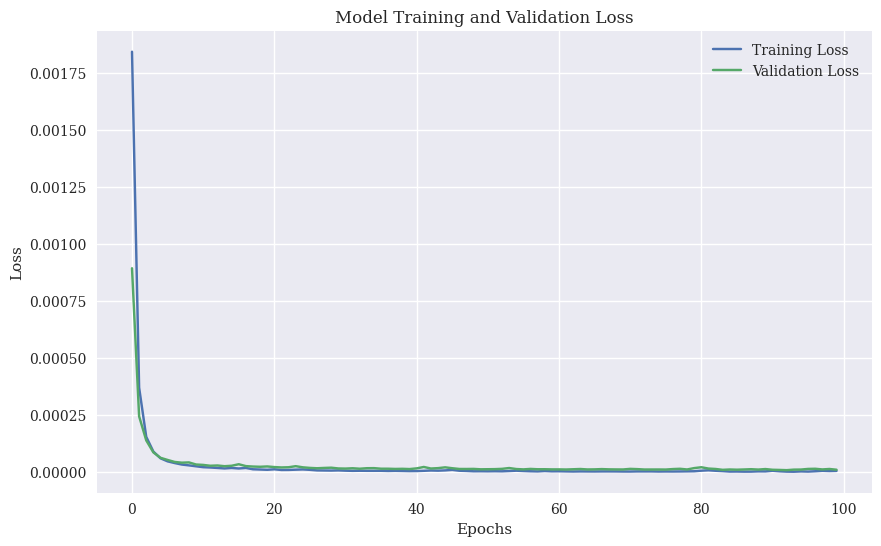

In [50]:
# Plotting training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# This plot is essential for understanding how the model learns over time. The training loss should generally decrease
# as the model gets better at making predictions on the training data. The validation loss gives an indication of how well
# the model generalizes to unseen data. If the validation loss decreases alongside the training loss, it suggests good generalization.
# If the validation loss begins to increase while training loss continues to decrease, this could indicate overfitting.

Mean Absolute Error (MAE): 0.001937860371204225
Mean Squared Error (MSE): 9.914039592371443e-06
Root Mean Squared Error (RMSE): 0.0031486567917719207


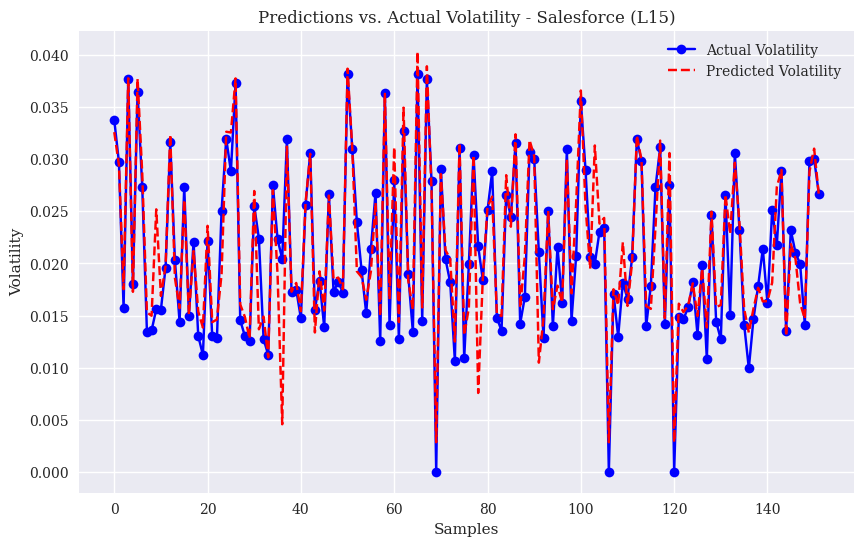

In [51]:
# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test_crm_L15, predictions)
mse = mean_squared_error(y_test_crm_L15, predictions)
rmse = mse ** 0.5  # Square root of MSE

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting Predictions vs Actual Data
plt.figure(figsize=(10, 6))
plt.plot(y_test_crm_L15, label='Actual Volatility', color='blue', marker='o')
plt.plot(predictions, label='Predicted Volatility', color='red', linestyle='--', marker='x')
plt.title('Predictions vs. Actual Volatility - Salesforce (L15)')
plt.xlabel('Samples')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# The plot and metrics provide a visual and quantitative assessment of the model's performance. The closer the predictions are to the actual values, the better the model. Differences between the predicted and actual values indicate prediction errors. The metrics quantify these errors, with lower values indicating better model performance.

## 1.6 - Goldman Sachs where L = 15
### Train the Model 

In [52]:
# Reshaping the input in order for train the model
X_train_reshaped_gs_L15 = X_train_scaled_gs_L15.reshape((X_train_scaled_gs_L15.shape[0], 15, 1))
X_test_reshaped_gs_L15 = X_test_scaled_gs_L15.reshape((X_test_scaled_gs_L15.shape[0], 15, 1))

# Check for NaNs and handle them

X_train_reshaped_gs_L15 = np.nan_to_num(X_train_reshaped_gs_L15)
X_test_reshaped_gs_L15 = np.nan_to_num(X_test_reshaped_gs_L15)
y_train_gs_L15 = np.nan_to_num(y_train_gs_L15)
y_test_gs_L15 = np.nan_to_num(y_test_gs_L15)


# L=15 days scenario for GS
history = model.fit(X_train_reshaped_gs_L15, y_train_gs_L15, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
16/16 [==============================] - 0s 20ms/step - loss: 6.0439e-05 - val_loss: 4.2284e-05
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 3.9276e-05 - val_loss: 6.7455e-05
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 3.6393e-05 - val_loss: 2.7028e-05
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 1.6315e-05 - val_loss: 2.2923e-05
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 1.7761e-05 - val_loss: 3.1016e-05
Epoch 6/100
16/16 [==============================] - 0s 14ms/step - loss: 2.2028e-05 - val_loss: 1.9905e-05
Epoch 7/100
16/16 [==============================] - 0s 14ms/step - loss: 1.4372e-05 - val_loss: 2.2707e-05
Epoch 8/100
16/16 [==============================] - 0s 15ms/step - loss: 1.2407e-05 - val_loss: 2.1902e-05
Epoch 9/100
16/16 [==============================] - 0s 16ms/step - loss: 9.3349e-06 - val_loss: 1.7908e-05
Epoch 10/100
16/16 [========

16/16 [==============================] - 0s 12ms/step - loss: 2.6804e-06 - val_loss: 1.4806e-05
Epoch 77/100
16/16 [==============================] - 0s 14ms/step - loss: 3.6797e-06 - val_loss: 2.7290e-05
Epoch 78/100
16/16 [==============================] - 0s 14ms/step - loss: 1.0310e-05 - val_loss: 2.1230e-05
Epoch 79/100
16/16 [==============================] - 0s 13ms/step - loss: 7.0843e-06 - val_loss: 1.7049e-05
Epoch 80/100
16/16 [==============================] - 0s 13ms/step - loss: 4.7735e-06 - val_loss: 1.7713e-05
Epoch 81/100
16/16 [==============================] - 0s 13ms/step - loss: 7.1463e-06 - val_loss: 1.4619e-05
Epoch 82/100
16/16 [==============================] - 0s 13ms/step - loss: 4.3933e-06 - val_loss: 1.4498e-05
Epoch 83/100
16/16 [==============================] - 0s 14ms/step - loss: 2.6350e-06 - val_loss: 2.1951e-05
Epoch 84/100
16/16 [==============================] - 0s 12ms/step - loss: 5.6592e-06 - val_loss: 1.5637e-05
Epoch 85/100
16/16 [============

### Evaluate the Model 

In [53]:
test_loss = model.evaluate(X_test_reshaped_gs_L15, y_test_gs_L15)
print(f"Test Loss: {test_loss}")

5/5 [==============================] - 0s 7ms/step - loss: 1.9128e-05
Test Loss: 1.9127634004689753e-05


### Make the Prediction

In [54]:
predictions = model.predict(X_test_reshaped_gs_L15)
print(predictions)

5/5 [==============================] - 0s 7ms/step
[[ 0.0275]
 [ 0.0183]
 [ 0.0148]
 [ 0.0147]
 [ 0.0153]
 [ 0.0146]
 [ 0.0232]
 [ 0.0136]
 [ 0.0136]
 [ 0.0209]
 [ 0.0089]
 [ 0.0148]
 [ 0.0209]
 [ 0.0153]
 [ 0.014 ]
 [ 0.0198]
 [ 0.0138]
 [ 0.0177]
 [ 0.0205]
 [ 0.0145]
 [ 0.0144]
 [ 0.0137]
 [ 0.0132]
 [ 0.0145]
 [ 0.0131]
 [ 0.013 ]
 [ 0.0234]
 [ 0.0167]
 [ 0.014 ]
 [ 0.014 ]
 [ 0.021 ]
 [ 0.018 ]
 [ 0.0317]
 [ 0.0182]
 [ 0.0218]
 [ 0.0173]
 [ 0.0133]
 [ 0.0204]
 [ 0.0177]
 [ 0.0169]
 [ 0.0134]
 [ 0.0185]
 [ 0.0144]
 [ 0.0136]
 [ 0.0147]
 [ 0.0139]
 [ 0.0202]
 [ 0.0145]
 [ 0.0138]
 [ 0.0161]
 [ 0.0256]
 [ 0.0227]
 [ 0.0151]
 [ 0.0165]
 [ 0.0147]
 [ 0.0244]
 [ 0.0172]
 [ 0.0145]
 [ 0.0149]
 [ 0.0156]
 [ 0.022 ]
 [ 0.0209]
 [ 0.0199]
 [ 0.0141]
 [ 0.0133]
 [ 0.0233]
 [ 0.0156]
 [ 0.0246]
 [ 0.017 ]
 [ 0.0011]
 [ 0.0115]
 [ 0.0165]
 [ 0.0148]
 [ 0.0136]
 [ 0.0228]
 [ 0.015 ]
 [ 0.0193]
 [ 0.0282]
 [ 0.0151]
 [ 0.0148]
 [ 0.0219]
 [ 0.0148]
 [ 0.0162]
 [ 0.0147]
 [ 0.0198]
 [ 0.0235]
 [ 

### Visualise the Outputs

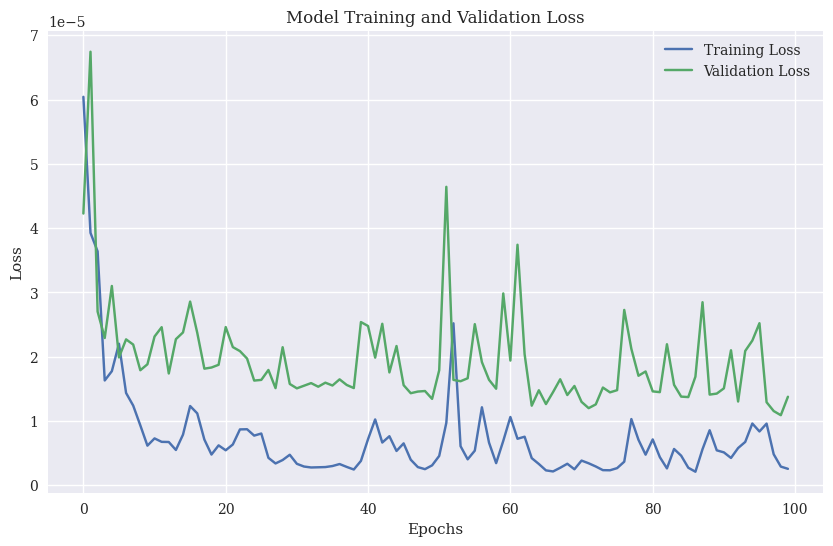

In [55]:
# Plotting training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# This plot is essential for understanding how the model learns over time. The training loss should generally decrease
# as the model gets better at making predictions on the training data. The validation loss gives an indication of how well
# the model generalizes to unseen data. If the validation loss decreases alongside the training loss, it suggests good generalization.
# If the validation loss begins to increase while training loss continues to decrease, this could indicate overfitting.

Mean Absolute Error (MAE): 0.0021932944129320884
Mean Squared Error (MSE): 1.9127632268638153e-05
Root Mean Squared Error (RMSE): 0.004373514864344027


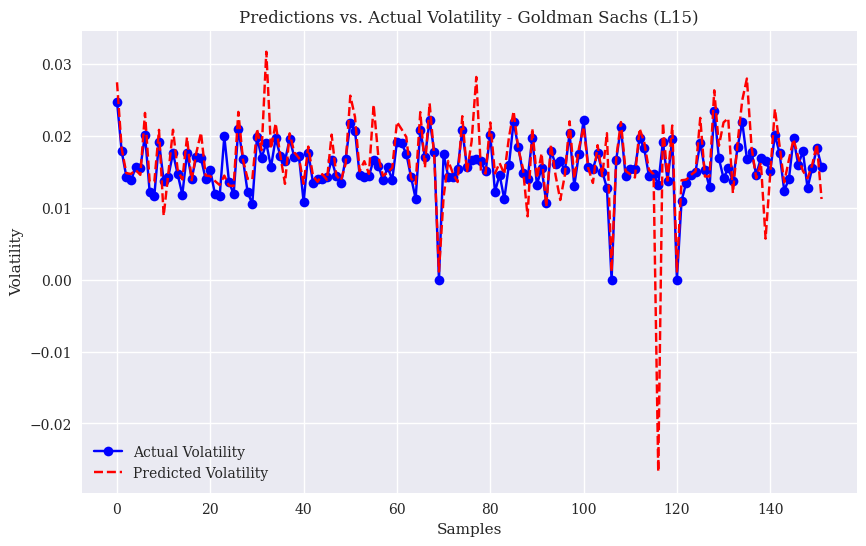

In [56]:
# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test_gs_L15, predictions)
mse = mean_squared_error(y_test_gs_L15, predictions)
rmse = mse ** 0.5  # Square root of MSE

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting Predictions vs Actual Data
plt.figure(figsize=(10, 6))
plt.plot(y_test_gs_L15, label='Actual Volatility', color='blue', marker='o')
plt.plot(predictions, label='Predicted Volatility', color='red', linestyle='--', marker='x')
plt.title('Predictions vs. Actual Volatility - Goldman Sachs (L15)')
plt.xlabel('Samples')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# The plot and metrics provide a visual and quantitative assessment of the model's performance. The closer the predictions are to the actual values, the better the model. Differences between the predicted and actual values indicate prediction errors. The metrics quantify these errors, with lower values indicating better model performance.

L 15 is very poor at predicting the volatility as seen above

## 1.7 - Salesforce where L = 20
### Complie the Model

In [57]:
model = build_rnn_model(input_shape=(20, 1))  # L is the length of input sequences and I have 1 feature

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

### Train the Model

In [58]:
# Reshaping the input in order for train the model
X_train_reshaped_crm_L20 = X_train_scaled_crm_L20.reshape((X_train_scaled_crm_L20.shape[0], 20, 1))
X_test_reshaped_crm_L20 = X_test_scaled_crm_L20.reshape((X_test_scaled_crm_L20.shape[0], 20, 1))

# Check for NaNs and handle them

X_train_reshaped_crm_L20 = np.nan_to_num(X_train_reshaped_crm_L20)
X_test_reshaped_crm_L20 = np.nan_to_num(X_test_reshaped_crm_L20)
y_train_crm_L20 = np.nan_to_num(y_train_crm_L20)
y_test_crm_L20 = np.nan_to_num(y_test_crm_L20)


# L=20 days scenario for CRM
history = model.fit(X_train_reshaped_crm_L20, y_train_crm_L20, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
16/16 [==============================] - 3s 43ms/step - loss: 0.0137 - val_loss: 0.0059
Epoch 2/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0019 - val_loss: 9.8869e-04
Epoch 3/100
16/16 [==============================] - 0s 17ms/step - loss: 5.8984e-04 - val_loss: 4.9875e-04
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 2.7713e-04 - val_loss: 1.5034e-04
Epoch 5/100
16/16 [==============================] - 0s 18ms/step - loss: 1.1303e-04 - val_loss: 8.7599e-05
Epoch 6/100
16/16 [==============================] - 0s 14ms/step - loss: 6.5579e-05 - val_loss: 8.5542e-05
Epoch 7/100
16/16 [==============================] - 0s 16ms/step - loss: 5.3094e-05 - val_loss: 5.6187e-05
Epoch 8/100
16/16 [==============================] - 0s 17ms/step - loss: 4.0017e-05 - val_loss: 5.0856e-05
Epoch 9/100
16/16 [==============================] - 0s 17ms/step - loss: 3.0405e-05 - val_loss: 3.8298e-05
Epoch 10/100
16/16 [====================

16/16 [==============================] - 0s 22ms/step - loss: 2.5890e-06 - val_loss: 2.9233e-05
Epoch 77/100
16/16 [==============================] - 0s 18ms/step - loss: 3.7313e-06 - val_loss: 3.2389e-05
Epoch 78/100
16/16 [==============================] - 0s 19ms/step - loss: 2.7184e-06 - val_loss: 2.9491e-05
Epoch 79/100
16/16 [==============================] - 0s 17ms/step - loss: 2.8645e-06 - val_loss: 2.9172e-05
Epoch 80/100
16/16 [==============================] - 0s 19ms/step - loss: 3.2879e-06 - val_loss: 3.4193e-05
Epoch 81/100
16/16 [==============================] - 0s 16ms/step - loss: 2.9784e-06 - val_loss: 2.9918e-05
Epoch 82/100
16/16 [==============================] - 0s 16ms/step - loss: 2.2920e-06 - val_loss: 3.1571e-05
Epoch 83/100
16/16 [==============================] - 0s 18ms/step - loss: 3.0232e-06 - val_loss: 3.2832e-05
Epoch 84/100
16/16 [==============================] - 0s 16ms/step - loss: 3.6608e-06 - val_loss: 3.2184e-05
Epoch 85/100
16/16 [============

### Evaluate the Model

In [59]:
test_loss = model.evaluate(X_test_reshaped_crm_L20, y_test_crm_L20)
print(f"Test Loss: {test_loss}")

5/5 [==============================] - 0s 7ms/step - loss: 3.3771e-05
Test Loss: 3.3771138987503946e-05


### Make prediction

In [60]:
predictions = model.predict(X_test_reshaped_crm_L20)
print(predictions)

5/5 [==============================] - 0s 7ms/step
[[ 0.0305]
 [ 0.0245]
 [ 0.0173]
 [ 0.0149]
 [ 0.0389]
 [ 0.0133]
 [ 0.0357]
 [ 0.0313]
 [ 0.0146]
 [ 0.0151]
 [ 0.0146]
 [ 0.0235]
 [ 0.0257]
 [ 0.036 ]
 [ 0.017 ]
 [ 0.0177]
 [ 0.0213]
 [ 0.017 ]
 [ 0.0154]
 [ 0.0106]
 [ 0.0257]
 [ 0.0212]
 [ 0.0191]
 [ 0.0202]
 [ 0.0157]
 [ 0.018 ]
 [ 0.0168]
 [ 0.0169]
 [ 0.0218]
 [ 0.0429]
 [ 0.0134]
 [ 0.0133]
 [ 0.0305]
 [ 0.0453]
 [ 0.0259]
 [ 0.0296]
 [ 0.0267]
 [ 0.043 ]
 [ 0.0311]
 [ 0.0206]
 [ 0.0137]
 [ 0.0151]
 [ 0.0331]
 [ 0.0158]
 [ 0.0142]
 [ 0.0153]
 [ 0.0299]
 [ 0.0289]
 [ 0.0147]
 [ 0.0135]
 [ 0.0154]
 [ 0.0145]
 [ 0.0292]
 [ 0.015 ]
 [ 0.0122]
 [ 0.0299]
 [ 0.0229]
 [ 0.0013]
 [ 0.0276]
 [ 0.017 ]
 [ 0.0134]
 [ 0.0254]
 [ 0.0199]
 [ 0.0286]
 [ 0.0207]
 [ 0.0273]
 [ 0.0379]
 [ 0.0151]
 [ 0.032 ]
 [ 0.0106]
 [ 0.0206]
 [ 0.0223]
 [ 0.0375]
 [ 0.0371]
 [ 0.0397]
 [ 0.0277]
 [ 0.0248]
 [-0.0158]
 [ 0.0163]
 [ 0.0261]
 [ 0.0188]
 [ 0.0089]
 [ 0.0368]
 [ 0.0134]
 [ 0.0154]
 [ 0.0129]
 [ 

### Visualise the outputs

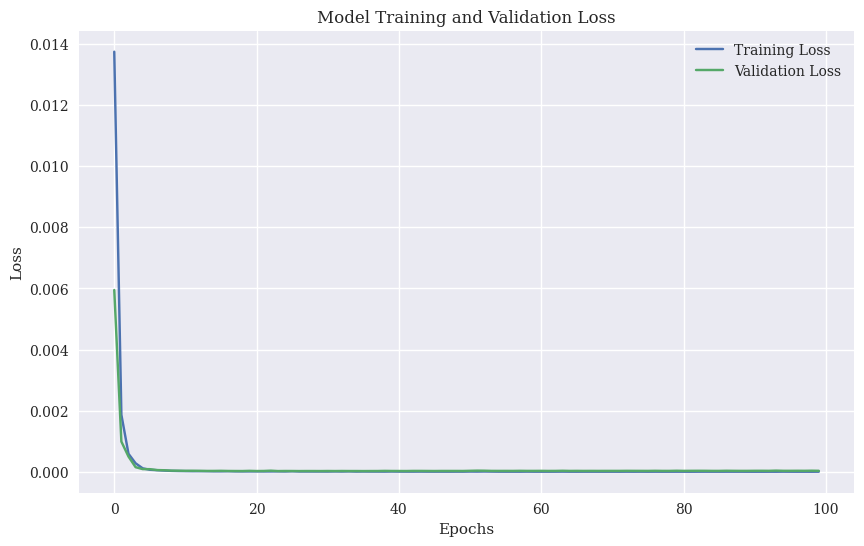

In [61]:
# Plotting training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# This plot is essential for understanding how the model learns over time. The training loss should generally decrease
# as the model gets better at making predictions on the training data. The validation loss gives an indication of how well
# the model generalizes to unseen data. If the validation loss decreases alongside the training loss, it suggests good generalization.
# If the validation loss begins to increase while training loss continues to decrease, this could indicate overfitting.

Mean Absolute Error (MAE): 0.0026131999186103073
Mean Squared Error (MSE): 3.377114489114308e-05
Root Mean Squared Error (RMSE): 0.005811294596829788


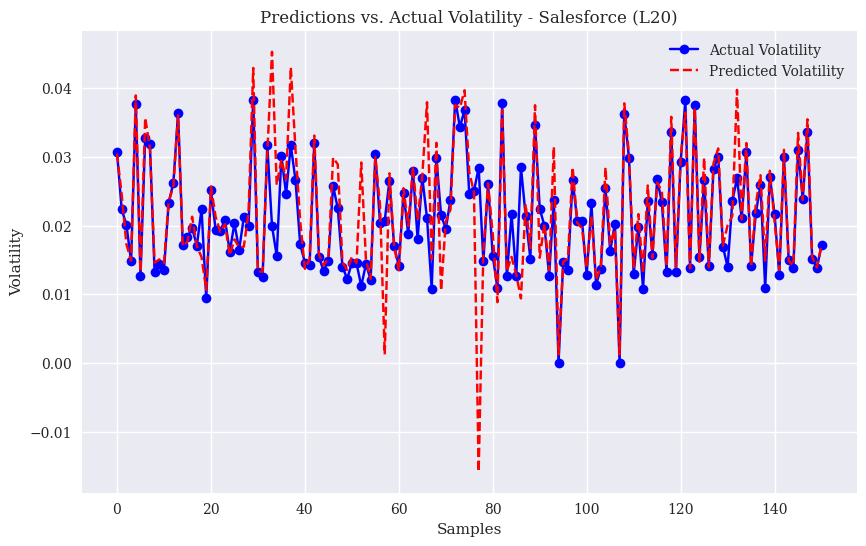

In [62]:
# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test_crm_L20, predictions)
mse = mean_squared_error(y_test_crm_L20, predictions)
rmse = mse ** 0.5  # Square root of MSE

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting Predictions vs Actual Data
plt.figure(figsize=(10, 6))
plt.plot(y_test_crm_L20, label='Actual Volatility', color='blue', marker='o')
plt.plot(predictions, label='Predicted Volatility', color='red', linestyle='--', marker='x')
plt.title('Predictions vs. Actual Volatility - Salesforce (L20)')
plt.xlabel('Samples')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# The plot and metrics provide a visual and quantitative assessment of the model's performance. The closer the predictions are to the actual values, the better the model. Differences between the predicted and actual values indicate prediction errors. The metrics quantify these errors, with lower values indicating better model performance.

## 1.8 - Goldman Sachs where L = 20

In [63]:
# Train the Model 
# Reshaping the input in order for train the model
X_train_reshaped_gs_L20 = X_train_scaled_gs_L20.reshape((X_train_scaled_gs_L20.shape[0], 20, 1))
X_test_reshaped_gs_L20 = X_test_scaled_gs_L20.reshape((X_test_scaled_gs_L20.shape[0], 20, 1))

# Check for NaNs and handle them

X_train_reshaped_gs_L20 = np.nan_to_num(X_train_reshaped_gs_L20)
X_test_reshaped_gs_L20 = np.nan_to_num(X_test_reshaped_gs_L20)
y_train_gs_L20 = np.nan_to_num(y_train_gs_L20)
y_test_gs_L20 = np.nan_to_num(y_test_gs_L20)


# L=20 days scenario for GS
history = model.fit(X_train_reshaped_gs_L20, y_train_gs_L20, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the Model
test_loss = model.evaluate(X_test_reshaped_gs_L20, y_test_gs_L20)
print(f"Test Loss: {test_loss}")

# Make Prediction
predictions = model.predict(X_test_reshaped_gs_L20)
print(predictions)

Epoch 1/100
16/16 [==============================] - 0s 24ms/step - loss: 5.9392e-05 - val_loss: 3.9478e-05
Epoch 2/100
16/16 [==============================] - 0s 17ms/step - loss: 2.8141e-05 - val_loss: 2.7669e-05
Epoch 3/100
16/16 [==============================] - 0s 18ms/step - loss: 1.8417e-05 - val_loss: 1.4836e-05
Epoch 4/100
16/16 [==============================] - 0s 19ms/step - loss: 1.5258e-05 - val_loss: 1.5901e-05
Epoch 5/100
16/16 [==============================] - 0s 16ms/step - loss: 1.3433e-05 - val_loss: 1.5805e-05
Epoch 6/100
16/16 [==============================] - 0s 18ms/step - loss: 9.4529e-06 - val_loss: 1.2904e-05
Epoch 7/100
16/16 [==============================] - 0s 17ms/step - loss: 8.2523e-06 - val_loss: 1.4788e-05
Epoch 8/100
16/16 [==============================] - 0s 22ms/step - loss: 9.2982e-06 - val_loss: 2.2630e-05
Epoch 9/100
16/16 [==============================] - 0s 17ms/step - loss: 8.9793e-06 - val_loss: 1.2448e-05
Epoch 10/100
16/16 [========

16/16 [==============================] - 0s 18ms/step - loss: 2.3638e-06 - val_loss: 1.1900e-05
Epoch 77/100
16/16 [==============================] - 0s 20ms/step - loss: 1.9912e-06 - val_loss: 9.3078e-06
Epoch 78/100
16/16 [==============================] - 0s 19ms/step - loss: 1.3112e-06 - val_loss: 8.7144e-06
Epoch 79/100
16/16 [==============================] - 0s 19ms/step - loss: 1.4799e-06 - val_loss: 1.0174e-05
Epoch 80/100
16/16 [==============================] - 0s 20ms/step - loss: 1.7282e-06 - val_loss: 1.2415e-05
Epoch 81/100
16/16 [==============================] - 0s 17ms/step - loss: 4.4618e-06 - val_loss: 1.8060e-05
Epoch 82/100
16/16 [==============================] - 0s 19ms/step - loss: 3.9309e-06 - val_loss: 1.9322e-05
Epoch 83/100
16/16 [==============================] - 0s 17ms/step - loss: 5.3968e-06 - val_loss: 1.1815e-05
Epoch 84/100
16/16 [==============================] - 0s 18ms/step - loss: 3.4704e-06 - val_loss: 9.2556e-06
Epoch 85/100
16/16 [============

### Visualise Outputs

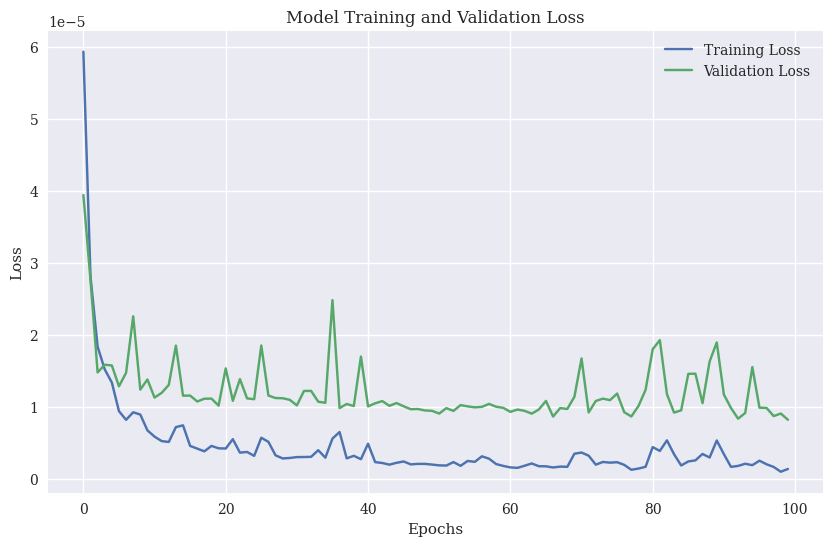

Mean Absolute Error (MAE): 0.0018345915966882873
Mean Squared Error (MSE): 1.6071191865567622e-05
Root Mean Squared Error (RMSE): 0.0040088891061698904


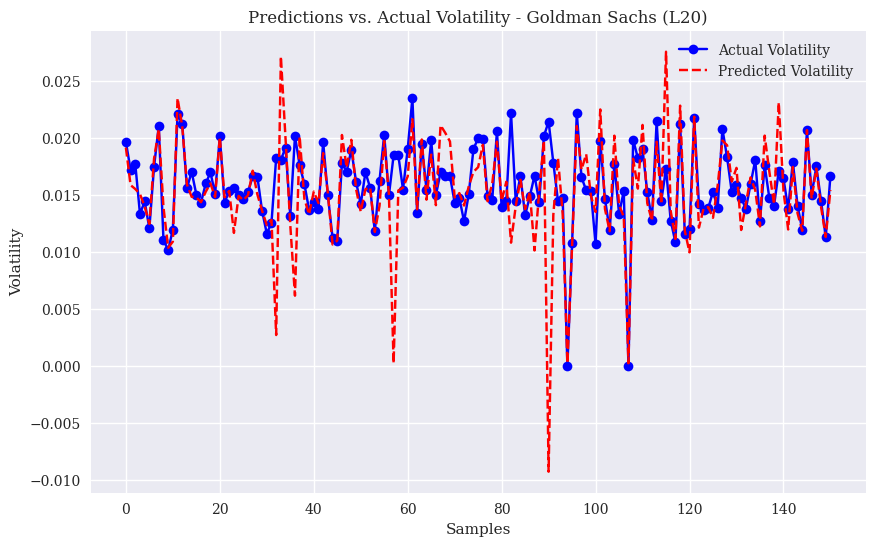

In [64]:
# Plotting training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# This plot is essential for understanding how the model learns over time. The training loss should generally decrease
# as the model gets better at making predictions on the training data. The validation loss gives an indication of how well
# the model generalizes to unseen data. If the validation loss decreases alongside the training loss, it suggests good generalization.
# If the validation loss begins to increase while training loss continues to decrease, this could indicate overfitting.

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test_gs_L20, predictions)
mse = mean_squared_error(y_test_gs_L20, predictions)
rmse = mse ** 0.5  # Square root of MSE

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting Predictions vs Actual Data
plt.figure(figsize=(10, 6))
plt.plot(y_test_gs_L20, label='Actual Volatility', color='blue', marker='o')
plt.plot(predictions, label='Predicted Volatility', color='red', linestyle='--', marker='x')
plt.title('Predictions vs. Actual Volatility - Goldman Sachs (L20)')
plt.xlabel('Samples')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# The plot and metrics provide a visual and quantitative assessment of the model's performance. The closer the predictions are to the actual values, the better the model. Differences between the predicted and actual values indicate prediction errors. The metrics quantify these errors, with lower values indicating better model performance.

## 1.9 - Salesforce where L =40
### Compile Model

In [65]:
model = build_rnn_model(input_shape=(40, 1))  # L is the length of input sequences and I have 1 feature

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [66]:
# Train the Model 
# Reshaping the input in order for train the model
X_train_reshaped_crm_L40 = X_train_scaled_crm_L40.reshape((X_train_scaled_crm_L40.shape[0], 40, 1))
X_test_reshaped_crm_L40 = X_test_scaled_crm_L40.reshape((X_test_scaled_crm_L40.shape[0], 40, 1))

# Check for NaNs and handle them

X_train_reshaped_crm_L40 = np.nan_to_num(X_train_reshaped_crm_L40)
X_test_reshaped_crm_L40 = np.nan_to_num(X_test_reshaped_crm_L40)
y_train_crm_L40 = np.nan_to_num(y_train_crm_L40)
y_test_crm_L40 = np.nan_to_num(y_test_crm_L40)


# L=40 days scenario for CRM
history = model.fit(X_train_reshaped_crm_L40, y_train_crm_L40, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the Model
test_loss = model.evaluate(X_test_reshaped_crm_L40, y_test_crm_L40)
print(f"Test Loss: {test_loss}")

# Make Prediction
predictions = model.predict(X_test_reshaped_crm_L40)
print(predictions)

Epoch 1/100
15/15 [==============================] - 3s 86ms/step - loss: 0.0087 - val_loss: 0.0033
Epoch 2/100
15/15 [==============================] - 0s 30ms/step - loss: 0.0012 - val_loss: 5.4649e-04
Epoch 3/100
15/15 [==============================] - 0s 24ms/step - loss: 3.3083e-04 - val_loss: 2.2587e-04
Epoch 4/100
15/15 [==============================] - 0s 26ms/step - loss: 1.1782e-04 - val_loss: 1.6423e-04
Epoch 5/100
15/15 [==============================] - 0s 22ms/step - loss: 8.2010e-05 - val_loss: 1.4520e-04
Epoch 6/100
15/15 [==============================] - 0s 25ms/step - loss: 6.1480e-05 - val_loss: 1.2287e-04
Epoch 7/100
15/15 [==============================] - 0s 24ms/step - loss: 4.9523e-05 - val_loss: 1.0145e-04
Epoch 8/100
15/15 [==============================] - 0s 20ms/step - loss: 4.0082e-05 - val_loss: 8.9210e-05
Epoch 9/100
15/15 [==============================] - 0s 23ms/step - loss: 3.4820e-05 - val_loss: 8.3668e-05
Epoch 10/100
15/15 [====================

15/15 [==============================] - 0s 26ms/step - loss: 2.6586e-06 - val_loss: 3.0561e-05
Epoch 77/100
15/15 [==============================] - 0s 24ms/step - loss: 2.5007e-06 - val_loss: 3.0146e-05
Epoch 78/100
15/15 [==============================] - 0s 25ms/step - loss: 2.5703e-06 - val_loss: 3.0242e-05
Epoch 79/100
15/15 [==============================] - 0s 20ms/step - loss: 2.5110e-06 - val_loss: 3.0787e-05
Epoch 80/100
15/15 [==============================] - 0s 23ms/step - loss: 2.3638e-06 - val_loss: 3.0730e-05
Epoch 81/100
15/15 [==============================] - 0s 26ms/step - loss: 2.5725e-06 - val_loss: 2.9907e-05
Epoch 82/100
15/15 [==============================] - 0s 20ms/step - loss: 2.3359e-06 - val_loss: 3.0224e-05
Epoch 83/100
15/15 [==============================] - 0s 22ms/step - loss: 2.5738e-06 - val_loss: 3.0186e-05
Epoch 84/100
15/15 [==============================] - 0s 22ms/step - loss: 2.4940e-06 - val_loss: 2.9815e-05
Epoch 85/100
15/15 [============

### Visualise Outputs

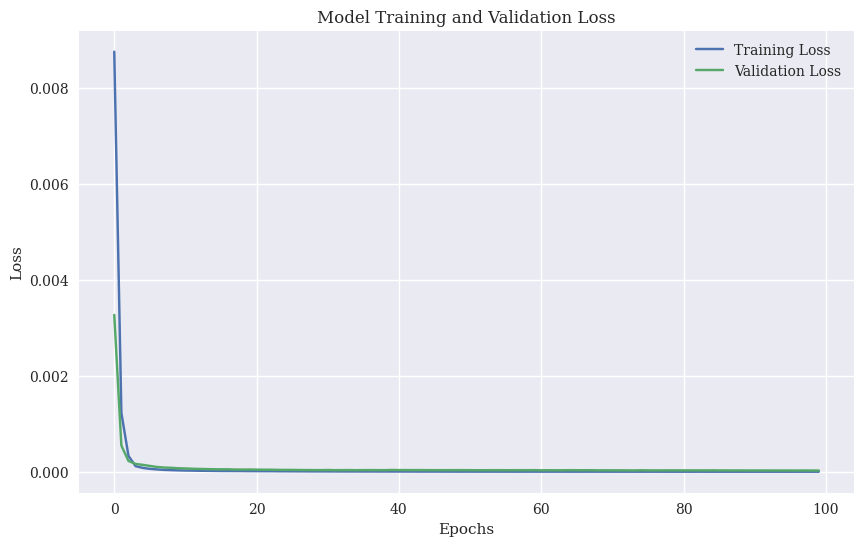

Mean Absolute Error (MAE): 0.0038283192882446475
Mean Squared Error (MSE): 0.0003808534082559656
Root Mean Squared Error (RMSE): 0.019515465873403217


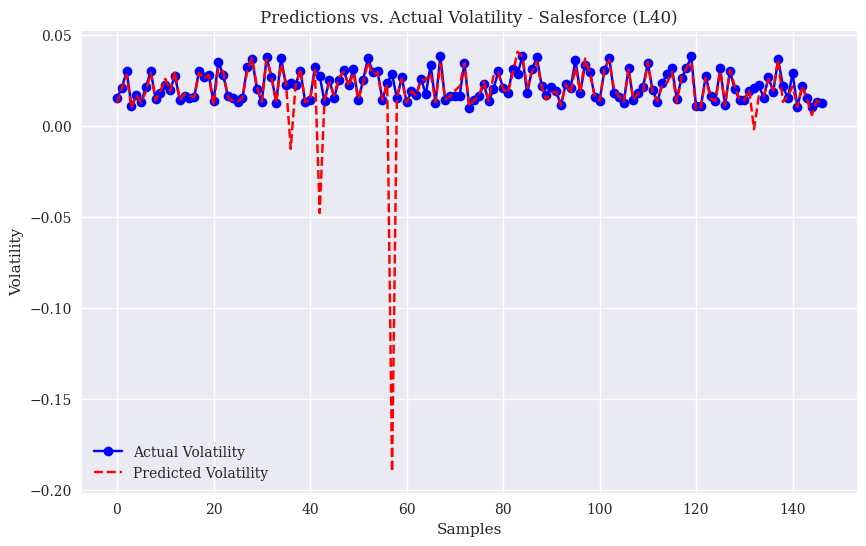

In [67]:
# Plotting training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# This plot is essential for understanding how the model learns over time. The training loss should generally decrease
# as the model gets better at making predictions on the training data. The validation loss gives an indication of how well
# the model generalizes to unseen data. If the validation loss decreases alongside the training loss, it suggests good generalization.
# If the validation loss begins to increase while training loss continues to decrease, this could indicate overfitting.

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test_crm_L40, predictions)
mse = mean_squared_error(y_test_crm_L40, predictions)
rmse = mse ** 0.5  # Square root of MSE

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting Predictions vs Actual Data
plt.figure(figsize=(10, 6))
plt.plot(y_test_crm_L40, label='Actual Volatility', color='blue', marker='o')
plt.plot(predictions, label='Predicted Volatility', color='red', linestyle='--', marker='x')
plt.title('Predictions vs. Actual Volatility - Salesforce (L40)')
plt.xlabel('Samples')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# The plot and metrics provide a visual and quantitative assessment of the model's performance. The closer the predictions are to the actual values, the better the model. Differences between the predicted and actual values indicate prediction errors. The metrics quantify these errors, with lower values indicating better model performance.

## 1.10 - Goldman Sachs where L = 40

In [68]:
# Train the Model 
# Reshaping the input in order for train the model
X_train_reshaped_gs_L40 = X_train_scaled_gs_L40.reshape((X_train_scaled_gs_L40.shape[0], 40, 1))
X_test_reshaped_gs_L40 = X_test_scaled_gs_L40.reshape((X_test_scaled_gs_L40.shape[0], 40, 1))

# Check for NaNs and handle them

X_train_reshaped_gs_L40 = np.nan_to_num(X_train_reshaped_gs_L40)
X_test_reshaped_gs_L40 = np.nan_to_num(X_test_reshaped_gs_L40)
y_train_gs_L40 = np.nan_to_num(y_train_gs_L40)
y_test_gs_L40 = np.nan_to_num(y_test_gs_L40)


# L=40 days scenario for CRM
history = model.fit(X_train_reshaped_gs_L40, y_train_gs_L40, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the Model
test_loss = model.evaluate(X_test_reshaped_gs_L40, y_test_gs_L40)
print(f"Test Loss: {test_loss}")

# Make Prediction
predictions = model.predict(X_test_reshaped_gs_L40)
print(predictions)

Epoch 1/100
15/15 [==============================] - 0s 31ms/step - loss: 1.7344e-04 - val_loss: 4.3055e-05
Epoch 2/100
15/15 [==============================] - 0s 22ms/step - loss: 7.4290e-05 - val_loss: 9.4999e-05
Epoch 3/100
15/15 [==============================] - 0s 22ms/step - loss: 5.6183e-05 - val_loss: 3.5518e-05
Epoch 4/100
15/15 [==============================] - 0s 28ms/step - loss: 2.7487e-05 - val_loss: 3.0683e-05
Epoch 5/100
15/15 [==============================] - 0s 20ms/step - loss: 1.9625e-05 - val_loss: 2.8359e-05
Epoch 6/100
15/15 [==============================] - 0s 22ms/step - loss: 1.6837e-05 - val_loss: 2.3433e-05
Epoch 7/100
15/15 [==============================] - 0s 26ms/step - loss: 1.3898e-05 - val_loss: 2.1804e-05
Epoch 8/100
15/15 [==============================] - 0s 29ms/step - loss: 1.2711e-05 - val_loss: 1.9579e-05
Epoch 9/100
15/15 [==============================] - 0s 31ms/step - loss: 1.2418e-05 - val_loss: 2.0343e-05
Epoch 10/100
15/15 [========

15/15 [==============================] - 0s 23ms/step - loss: 1.8261e-06 - val_loss: 1.2970e-05
Epoch 77/100
15/15 [==============================] - 0s 25ms/step - loss: 1.8237e-06 - val_loss: 1.2584e-05
Epoch 78/100
15/15 [==============================] - 0s 25ms/step - loss: 1.8831e-06 - val_loss: 1.2598e-05
Epoch 79/100
15/15 [==============================] - 0s 29ms/step - loss: 2.1188e-06 - val_loss: 1.2858e-05
Epoch 80/100
15/15 [==============================] - 0s 27ms/step - loss: 2.5773e-06 - val_loss: 1.2957e-05
Epoch 81/100
15/15 [==============================] - 0s 29ms/step - loss: 2.3625e-06 - val_loss: 1.2620e-05
Epoch 82/100
15/15 [==============================] - 0s 25ms/step - loss: 1.8193e-06 - val_loss: 1.2784e-05
Epoch 83/100
15/15 [==============================] - 0s 25ms/step - loss: 1.5445e-06 - val_loss: 1.2386e-05
Epoch 84/100
15/15 [==============================] - 0s 25ms/step - loss: 1.6770e-06 - val_loss: 1.2504e-05
Epoch 85/100
15/15 [============

### Visualise the Outputs

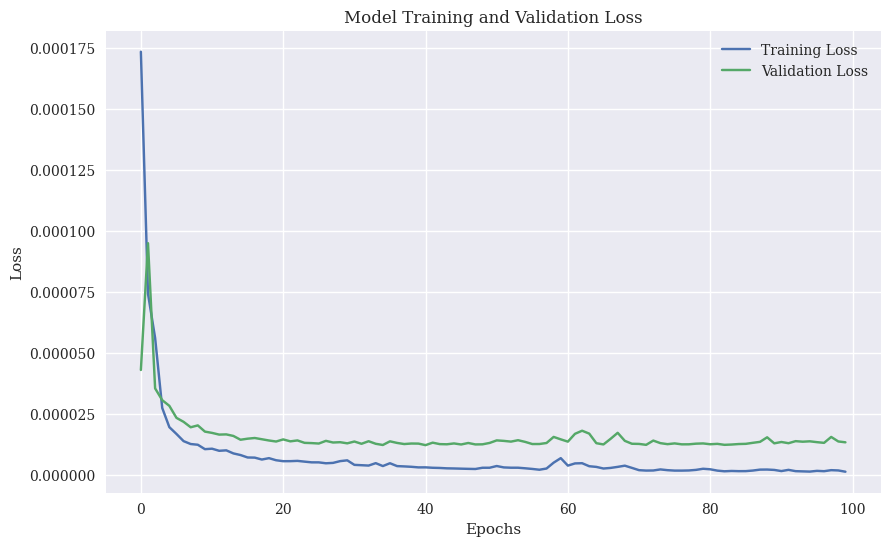

Mean Absolute Error (MAE): 0.001888303478914184
Mean Squared Error (MSE): 7.614613690366779e-06
Root Mean Squared Error (RMSE): 0.002759458948846092


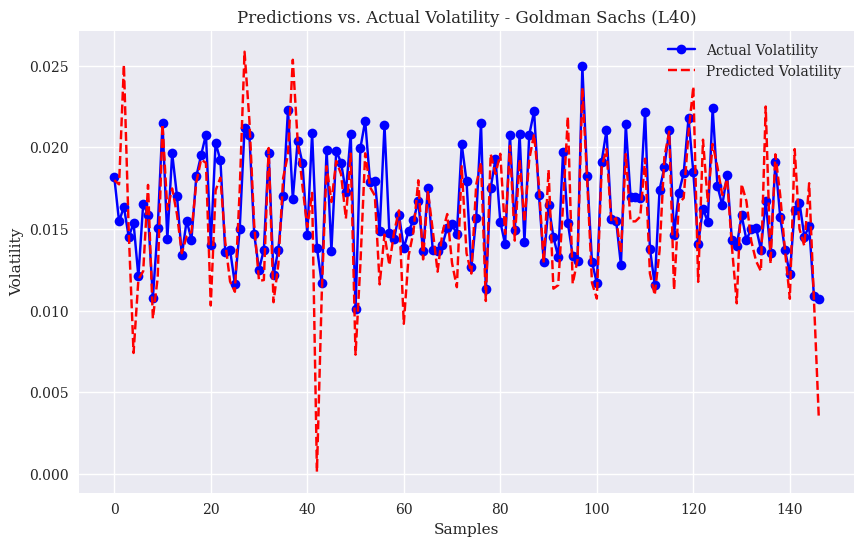

In [69]:
# Plotting training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# This plot is essential for understanding how the model learns over time. The training loss should generally decrease
# as the model gets better at making predictions on the training data. The validation loss gives an indication of how well
# the model generalizes to unseen data. If the validation loss decreases alongside the training loss, it suggests good generalization.
# If the validation loss begins to increase while training loss continues to decrease, this could indicate overfitting.

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test_gs_L40, predictions)
mse = mean_squared_error(y_test_gs_L40, predictions)
rmse = mse ** 0.5  # Square root of MSE

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting Predictions vs Actual Data
plt.figure(figsize=(10, 6))
plt.plot(y_test_gs_L40, label='Actual Volatility', color='blue', marker='o')
plt.plot(predictions, label='Predicted Volatility', color='red', linestyle='--', marker='x')
plt.title('Predictions vs. Actual Volatility - Goldman Sachs (L40)')
plt.xlabel('Samples')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# The plot and metrics provide a visual and quantitative assessment of the model's performance. The closer the predictions are to the actual values, the better the model. Differences between the predicted and actual values indicate prediction errors. The metrics quantify these errors, with lower values indicating better model performance.